In [1]:
print('Kernel Initialized')
#pid 17542

Kernel Initialized


In [2]:
# Imports
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
from utils import Utils
import plot_utils as plotting
import toml
from sklearn import preprocessing, model_selection, metrics
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use("seaborn-v0_8-whitegrid")
#plt.style.use("seaborn-v0_8")
#import mplhep as hep
#hep.style.use(hep.style.ATLAS)
from scipy.special import logit, expit
import os

import verstack
import optuna
from iminuit import Minuit
import scipy
import lightgbm

random.seed(42)

2023-02-19 16:34:20.582146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 16:34:22.607084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-19 16:34:22.607216: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-19 16:34:52.111237: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [3]:
config = toml.load('config.toml')
Storage = Utils.HDF5_IO(config['PATHS']['Storage'])

In [4]:
def Data_loader():
    print('Loading MC signal..')
    B_masses = ['B_mass', 'B_mass_true','B_Bbar_mass_closer_PDG','Bbar_mass','BeeKst_B_mass','BeeKst_Bbar_mass','B_mass_Kstar_mass_closer']

    SIG_MC=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['USR'], columns=None, use_threads=True, storage_options=None)
    SIG_MC = SIG_MC.query(Utils.selection_cuts()['usr_lowq2'])
    SIG_MC.drop(SIG_MC[~((SIG_MC.BeeKst_isTrueNonresBd==1) | (SIG_MC.BeeKst_isTrueNonresBdbar==1))].index,inplace=True)
    SIG_MC.drop(SIG_MC[(SIG_MC.BeeKst_isTrueNonresBd==1)].index[config['ML_config']['N_Signal']['Bd']:],inplace=True)
    SIG_MC.drop(SIG_MC[(SIG_MC.BeeKst_isTrueNonresBdbar==1)].index[config['ML_config']['N_Signal']['BdBar']:],inplace=True)


    label = (SIG_MC.info_sample == 0)*0
    for i in config['labels Sig_VS_Bkg']:
        label += (SIG_MC.info_sample == str(i))*config['labels Sig_VS_Bkg'][str(i)]

    #SIG_MC=SIG_MC.drop(columns=info_features)
    #SIG_MC=SIG_MC.drop(columns=B_masses)
    print('Colomns of only on value is removed..')
    SIG_MC=SIG_MC.drop(SIG_MC.std()[(SIG_MC.std() == 0)].index, axis=1)
    print('Dublecates is removed..')
    SIG_MC=SIG_MC.loc[:,~SIG_MC.T.duplicated(keep='last')]
    SIG_MC['label'] = label
    SIG_MC['label'].astype(int)


    print('Loading background sidebands..')
    BKG_SB=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['SB'], columns=None, use_threads=True, storage_options=None)
    BKG_SB = BKG_SB.query(Utils.selection_cuts()['nn1trb_lowq2'])
    BKG_SB.drop(BKG_SB.index[config['ML_config']['N_background']:],inplace=True)
    label = (BKG_SB.info_sample == 0)*0
    for i in config['labels Sig_VS_Bkg']:
        label += (BKG_SB.info_sample == str(i))*config['labels Sig_VS_Bkg'][str(i)]
    BKG_SB['label'] = label
    BKG_SB['label'].astype(int)

    print('Loading background signal region..')
    BKG_SR=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['SR'], columns=None, use_threads=True, storage_options=None)
    BKG_SR = BKG_SR.query(Utils.selection_cuts()['nn2trb_lowq2'])
    BKG_SR.drop(BKG_SR.index[config['ML_config']['N_background']:],inplace=True)
    label = (BKG_SR.info_sample == 0)*0
    for i in config['labels Sig_VS_Bkg']:
        label += (BKG_SR.info_sample == str(i))*config['labels Sig_VS_Bkg'][str(i)]
    BKG_SR['label'] = label
    BKG_SR['label'].astype(int)

    print('Loading MC background..')
    BKG_MC=pd.read_feather(path=config['train_files']['Bkg_MC'], columns=None, use_threads=True, storage_options=None)
    BKG_MC = BKG_MC.query(Utils.selection_cuts()['main'])
    BKG_MC.info_sample = 'BKG_MC'
    label = (BKG_MC.info_sample == 0)*0
    for i in config['labels Sig_VS_Bkg']:
        label += (BKG_MC.info_sample == str(i))*config['labels Sig_VS_Bkg'][str(i)]
    BKG_MC['label'] = label
    BKG_MC['label'].astype(int)


    # Generate tests..
    print('Loading tests..')
    BKG_MC_test=pd.read_feather(path=config['train_files']['Bkg_MC'], columns=None, use_threads=True, storage_options=None)
    BKG_MC_test = BKG_MC_test.query(Utils.selection_cuts()['main'])
    BKG_MC_test.info_sample = 'BKG_MC_test'
    BKG_MC_test['label'] = 1


    BKG_SB_test=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['SB'], columns=None, use_threads=True, storage_options=None)
    BKG_SB_test = BKG_SB_test.query(Utils.selection_cuts()['nn1trb_lowq2'])
    BKG_SB_test.drop(BKG_SB_test.index[len(BKG_MC_test):],inplace=True)
    BKG_SB_test['label'] = 0

    BKG_SR_test=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['SR'], columns=None, use_threads=True, storage_options=None)
    BKG_SR_test = BKG_SR_test.query(Utils.selection_cuts()['nn2trb_lowq2'])
    BKG_SR_test.drop(BKG_SR_test.index[len(BKG_MC_test):],inplace=True)
    BKG_SR_test['label'] = 0


    return SIG_MC, BKG_SB, BKG_SR, BKG_MC, {'SB':BKG_SB_test, 'SR': BKG_SR_test, 'MC': BKG_MC_test }

SIG_MC, BKG_SB, BKG_SR, BKG_MC, MC_tests = Data_loader()


Loading MC signal..
Colomns of only on value is removed..
Dublecates is removed..
Loading background sidebands..
Loading background signal region..
Loading MC background..
Loading tests..


In [5]:
info_features = config['features']['info_features'] + ['track_multiplicity_after_cuts', 'electron_multiplicity_after_cuts', 'entry', 'subentry','mc_channel_number','event_number']
B_masses = ['B_mass', 'B_mass_true','B_Bbar_mass_closer_PDG','Bbar_mass','BeeKst_B_mass','BeeKst_Bbar_mass','B_mass_Kstar_mass_closer']
non_contributing_features = []
bad_features = ['diElectron_mass', 'BeeKst_PV_minZ0_y', 'BeeKst_PV_minA0_y', 'BeeKst_PV_minZ0_x']
feature_remove = ['label'] + info_features + B_masses + non_contributing_features + bad_features

#features = [i for i in list(SIG_MC.columns) if i not in feature_remove]


features = ['trackMinus_pT', 'BeeKst_Bbar_tau_invM_PVMinA0', 'electron_LHTightIsEMValue', 'dR_electron_trackPlus', 'track1_p', 'Lxy_significance_over_B_chi2', 'trackPlus_chi2_over_nDoF', 'trackMinus_p', 'diMeson_Kpi_piK_mass_ratio', 'mass_electron_trackMinus_kaon', 'track1_iso_c40', 'mass_electron_trackPlus_kaon', 'BeeKst_PV_minZ0_z_err', 'diMeson_Kpi_piK_mass_pT_ratio', 'B_chi2', 'dPhi_diElectron_trackMinus', 'mass_electron_trackPlus_pion', 'diMeson_piK_mass_pT', 'dR_trackPlus_trackMinus', 'electron1_pT', 'BeeKst_diElectron_pT', 'diElectron_pvalue', 'energy_trackPlus_pion', 'diMeson_angle_beta', 'B_chi2_over_nDoF', 'BeeKst_meson0_qOverP', 'dR_diElectron_trackPlus', 'BeeKst_z0_maxSumPt2', 'B_pvalue', 'positron_pT', 'diMeson_Kpi_piK_mass_diff', 'diElectron_iso_m25', 'diMeson_KK_mass', 'positron_ECIDSResult', 'diElectron_chi2_over_nDoF', 'BeeKst_diElectron_vtx_y_err', 'tracks_dEdx_diff', 'dPhi_positron_electron', 'BeeKst_meson1_d0', 'BeeKst_a0xy_maxSumPt2', 'BeeKst_diMeson_vtx_y_err', 'positron_p', 'tracks_dEdx_sum', 'BeeKst_x_err', 'a0_significance', 'mass_positron_trackMinus_pion', 'BeeKst_PV_minA0_y_err', 'dPhi_electron_trackMinus', 'electron1_p', 'diElectron_iso_m15', 'BeeKst_diMeson_vtx_z_err', 'diMeson_Kpi_mass', 'mass_electron_trackMinus_pion', 'electron0_pT', 'BeeKst_diElectron_vtx_x_err', 'BeeKst_meson0_passLoosePrimary', 'd_B_diMeson_significance', 'positron_nDoF', 'dR_positron_trackPlus', 'B_pT', 'BeeKst_Lxy_minA0_err', 'diElectron_iso_m10', 'diMeson_Kpi_piK_mass_pT_diff', 'BeeKst_a0_maxSumPt2_err', 'electron0_p', 'electron_chi2_over_nDoF', 'electron_p', 'dR_positron_Kstar', 'diMeson_piK_mass', 'BeeKst_z_err', 'track1_pT', 'BeeKst_diMeson_pT', 'trackPlus_pvalue', 'track0_dEdx', 'BeeKst_PV_minA0_x', 'diElectron_iso_m30', 'BeeKst_meson1_qOverP', 'diElectron_iso_m00', 'positron_LHMediumIsEMValue', 'dR_electron_Kstar', 'electron0_iso_c40', 'dR_electron_trackMinus', 'diMeson_Kpi_mass_pT', 'positron_chi2', 'cos_Theta_pseudo_err', 'dR_positron_electron', 'BeeKst_y', 'trackPlus_p', 'positron_ptvarcone40_TightTTVALooseCone_pt1000', 'electron_LHMediumIsEMValue', 'electron_ptvarcone40_TightTTVALooseCone_pt1000', 'BeeKst_B_mass_err', 'diElectron_pT', 'track1_dEdx', 'BeeKst_Bbar_tau_invM_PVMaxSumPt2_err', 'BeeKst_PV_minZ0_x_err', 'mass_pionKaon_kaonPion_significance', 'mass_positron_trackMinus_kaon', 'mass_pionKaon_kaonPion_ratio', 'mass_positron_trackPlus_kaon', 'd_B_diElectron_significance', 'electron1_iso_c15', 'dR_positron_trackMinus', 'd_diMeson_diElectron_significance', 'diElectron_p', 'positron_iso_c15', 'angle_pp_plane_ee_plane', 'B_p', 'angle_ee_plane_mm_plane', 'BeeKst_PV_minZ0_y_err', 'trackPlus_nDoF', 'BeeKst_diElectron_vtx_z_err', 'trackMinus_chi2_over_nDoF', 'diMeson_angle_beta_sym', 'angle_pp_plane_mm_plane', 'trackPlus_dEdx', 'diElectron_angle_alpha_sym', 'trackMinus_pvalue', 'trackMinus_chi2', 'diMeson_angle_alpha_sym', 'BeeKst_PV_minA0_x_err', 'trackPlus_pT', 'diElectron_angle_alpha', 'BeeKst_PV_minA0_z_err', 'kaon_pT', 'BeeKst_meson0_d0', 'diElectron_angle_beta', 'BeeKst_B_tau_invM_PVMaxSumPt2_err', 'dPhi_trackPlus_trackMinus', 'diMeson_pipi_mass', 'tracks_dEdx_ratio', 'trackMinus_nDoF', 'BeeKst_diMeson_vtx_x_err', 'mass_positron_trackPlus_pion', 'electron_iso_c35', 'track0_iso_c40', 'diMeson_Kpi_piK_mass_avg', 'BeeKst_meson1_passTightPrimary', 'electron_pT', 'BeeKst_diMeson_pz', 'trackPlus_iso_c35', 'Lxy_significance', 'trackMinus_dEdx', 'BeeKst_electron1_qOverP', 'diMeson_Kpi_piK_mass_closer_PDG', 'diElectron_iso_m20', 'dR_diElectron_Kstar', 'diElectron_iso_m05', 'dR_diMeson_B_diElectron', 'pion_pT', 'angle_vtx_plane_ee_plane', 'track0_pT', 'dPhi_diElectron_trackPlus', 'electron0_pz', 'BeeKst_Bbar_mass_err', 'BeeKst_a0xy_maxSumPt2_err', 'BeeKst_electron0_d0', 'BeeKst_a0xy_minA0']

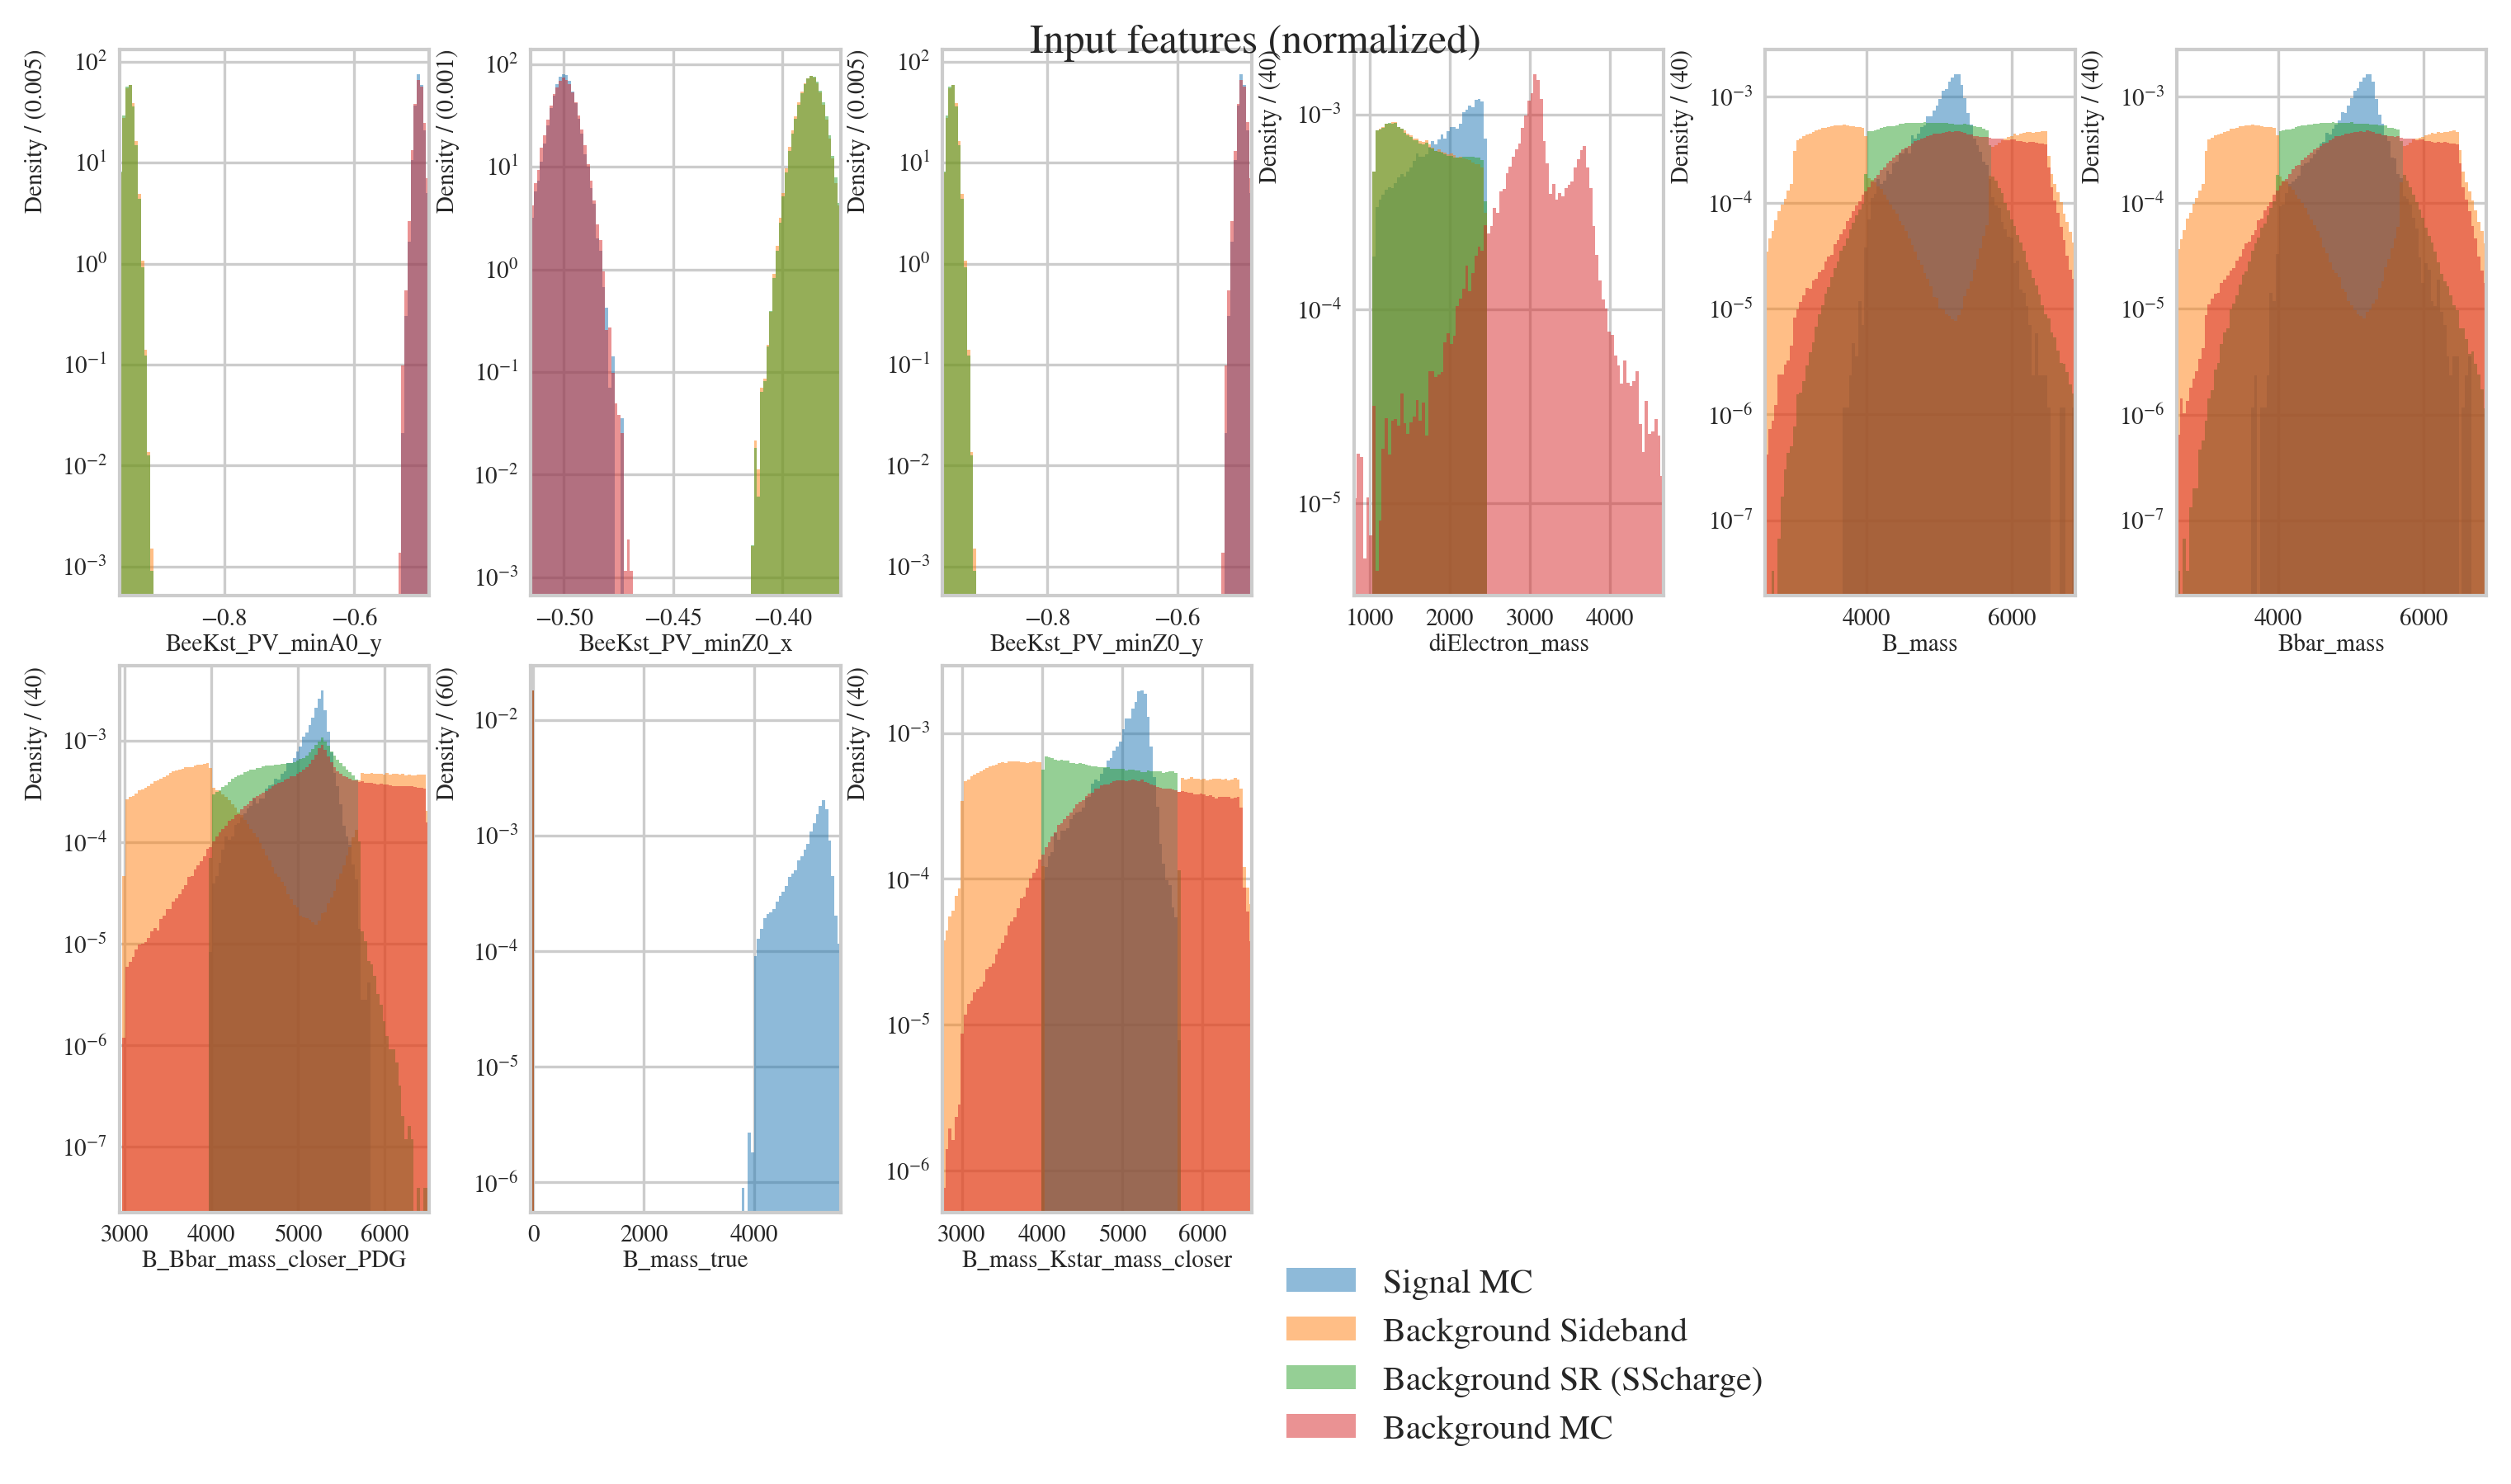

In [6]:
remove_feature_for_plot = [i for i in list(SIG_MC.columns) if i in B_masses+bad_features]
mpl.rc('font', **{'family' : 'stixgeneral'})  # pass in the font dict as kwargs
mpl.rc('text', **{'usetex': False})
mpl.rc('mathtext', **{'fontset': 'stix'})


def plot_pre_processed_data(data:list = [], labels:list = [],n_cols:int=6):

    assert len(data)>0, 'Data list is empty.'
    assert len(labels) == len(data), 'label list and data list is not equal.'
    assert np.all([item.shape[1] for item in data]), 'All elements in data list has to have same amount of columns.'
    for i in range(len(data)):
        assert list(data[0].columns) == list(data[i].columns), 'Not all columns are equal'

    fig = plt.figure(figsize=(10,5),dpi=300, tight_layout=True)
    fig.suptitle('Input features (normalized)')

    feature_names = list(data[0].columns)

    nrows = data[0].shape[1] // n_cols + (data[0].shape[1] % n_cols > 0)

    for i in range(data[0].shape[1]):
        
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, n_cols, i+1)
        
        # filter df and plot ticker on the new subplot axis
        
        plot_bottom = np.array([np.percentile(item.iloc[:, i], 1) for item in data])
        plot_top = np.array([np.percentile(item.iloc[:, i], 99) for item in data])
        ypad = 0.03*(plot_top - plot_bottom)

        min_range = np.min(plot_bottom) - np.max(ypad)
        max_range = np.max(plot_top) + np.min(ypad)
        Bin = 100
        bindwidth = (max_range - min_range)/Bin
        
     
        bindwidth_str = str(float(f"{bindwidth:.1g}")).split('.')[0] if float(str(float(f"{bindwidth:.1g}")).split('.')[-1]) == 0 else str(float(f"{bindwidth:.1g}"))

        
        plot = [item.iloc[:, i] for item in data]
        for j in range(len(plot)):
            ax.hist(plot[j],bins=Bin, range=(min_range,max_range),alpha=0.5, label=labels[j],density=True)

        ax.set_ylabel(f"Density / ({bindwidth_str})", loc ='top',size=7)
        
        ax.set(yscale='log',xlim=(min_range,max_range))
        #ax.set(yticks=[],xticks=[])
        ax.set_xlabel(feature_names[i],fontsize=7,labelpad=0.8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.tick_params(axis='both', which='minor', labelsize=7) 
        #ax.yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=5))
        ax.xaxis.offsetText.set_fontsize(5)


    plt.tight_layout(pad=0.2)
    fig.subplots_adjust(top = 0.96,bottom=0.02)

    ax.legend(bbox_to_anchor=(0.5,0.0),
                    bbox_transform=fig.transFigure, mode="expand", ncol=1)

    
    plt.savefig(config['PATHS']['figure_save']+"X_train_features.pdf",bbox_inches = 'tight')

    plt.show()

plot_pre_processed_data(data=[SIG_MC[remove_feature_for_plot],BKG_SB[remove_feature_for_plot],BKG_SR[remove_feature_for_plot],BKG_MC[remove_feature_for_plot]], labels=['Signal MC', 'Background Sideband', 'Background SR (SScharge)', 'Background MC'])

In [7]:
def train_test_split_stratified(X):
    random.seed(42)
    ratios = {
        'train': 0.7,
        'valid': 0.0,
        'test': 0.30}
    np.random.seed(42)
    X_train, X_rem, y_train, y_rem = model_selection.train_test_split(X, X.label, train_size=ratios['train'],stratify=X.label, shuffle=True,random_state=42)
    if ratios['valid'] == 0:
        X_test = X_rem
        y_test = y_rem
        return {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}
    else:
        X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_rem, y_rem, test_size=(ratios['test']/(1-ratios['train'])),stratify=y_rem,shuffle=True,random_state=42)
        return {'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid, 'X_test': X_test, 'y_test': y_test}


In [8]:
# Split and Scale
Sig_vs_BKG_SB = pd.concat([SIG_MC,BKG_SB,BKG_MC.query(Utils.selection_cuts()['MC2'])])
Sig_vs_BKG_SB_MC_test = pd.concat([MC_tests['SB'],MC_tests['MC']])

Sig_vs_BKG_SB_splits = train_test_split_stratified(Sig_vs_BKG_SB)
Utils.fit_scaler_to_train(Storage,Sig_vs_BKG_SB_splits['X_train'][features],root_tag='BDT_SB_iter2')
Sig_vs_BKG_SB_splits['X_train_scaled'] = Utils.pd_scale(Storage,Sig_vs_BKG_SB_splits['X_train'][features], root_tag= 'BDT_SB_iter2', target_tag = 'X_train')
Sig_vs_BKG_SB_splits['X_test_scaled'] = Utils.pd_scale(Storage,Sig_vs_BKG_SB_splits['X_test'][features], root_tag= 'BDT_SB_iter2', target_tag = 'X_test')


In [9]:
%%capture --no-stdout

def Run_tuner(X_,y_,Storage=Storage,root_tag='BDT_SB'):

    assert str(type(Storage).__module__) == "Storage.Global", "Input Storage is not a correct global storage initialized from the HDF5_IO-function"

    np.random.seed(42)
    #print(f"Training LGBM with {Storage.read_pd(key=f"{root_tag}/X_train").shape[1]} features")
    tuner = verstack.LGBMTuner(metric = 'log_loss',trials=100, visualization = False, seed = 42,verbosity=1)
    
    tuner.fit(X=X_,y=y_.astype(int).squeeze())

    Storage.write_pd(key=f"{root_tag}/tuner", df = tuner.study.trials_dataframe(attrs=('number', 'value', 'params', 'state','intermediate_values'),multi_index=True),overwrite=True)
    Storage.write_pd(key=f"{root_tag}/tuner_param_imp", df = pd.DataFrame([dict(optuna.importance.get_param_importances(tuner.study).items())]).T.rename(columns={0:'value'}),overwrite=True)
    Storage.save_lgbm(key=f"{root_tag}/model",tuner=tuner, feature_names = list(X_.columns), overwrite=True)
    Storage.write_pd(key=f"{root_tag}/best_params", df = pd.DataFrame([tuner.best_params]).T, overwrite=True)
    print('Done with training model')
    return tuner

#tuner = Run_tuner(X_=Sig_vs_BKG_SB_splits['X_train_scaled'],y_=Sig_vs_BKG_SB_splits['y_train'],root_tag='BDT_SB_iter2')



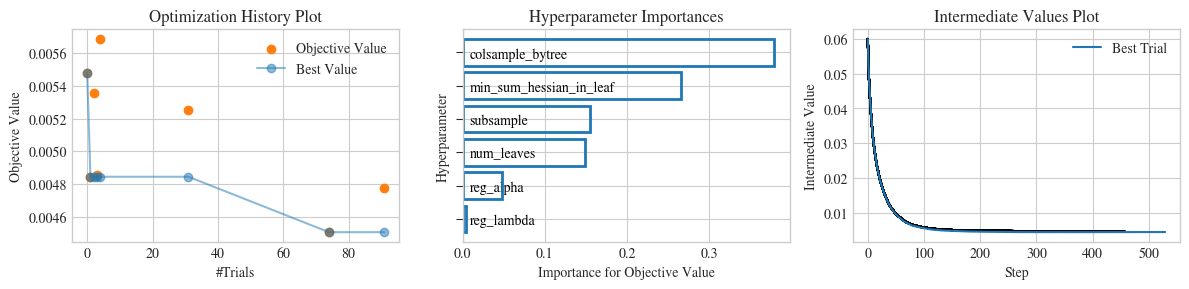

In [10]:
def Verstack_Optimization_plots(root_tag:str=None):
    P = plotting.Verstack_train_plots()
    fig = plt.figure(figsize=(12,3))
    P.plot_optimization_history(Storage.read_pd(key=f"{root_tag}/tuner"),fig=fig,placement=131)
    P.plot_param_imp(Storage.read_pd(key=f"{root_tag}/tuner_param_imp"),fig=fig,placement=132)
    P.plot_intermediate(Storage.read_pd(key=f"{root_tag}/tuner"),fig=fig,placement=133)
    plt.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+f"{root_tag}__optimization",bbox_inches = 'tight')
    plt.show()

Verstack_Optimization_plots(root_tag='BDT_SB_iter2')


In [11]:
def one_BDT_predicter(Storage,X_target=None,root_tag:str = ''):
    X = X_target.copy()
    XX = X_target.copy()
    
    model = Storage.load_lgbm(key=f"{root_tag}/model")
    feat_idx = model.feature_name()
    X=X[feat_idx]

    X_scaled = Utils.pd_scale(Storage,X, root_tag= root_tag)
    BDT_scores = model.predict(X_scaled.reindex(columns=feat_idx))

    XX[f"P_{root_tag}"] = BDT_scores
    
    return XX
    

In [12]:
BDT_SB_test=one_BDT_predicter(Storage,X_target = Sig_vs_BKG_SB_splits['X_test'],root_tag='BDT_SB_iter2')
Sig_vs_BKG_SB_MC_test=one_BDT_predicter(Storage,X_target = Sig_vs_BKG_SB_MC_test ,root_tag='BDT_SB_iter2')


In [13]:
from typing import Optional
class plot_response():
    def __init__(self, input_data: pd.core.frame.DataFrame = None, threshold: Optional[float]=None, root_tag:str='BDT1',test_data:bool=False):
        self.input_data = input_data
        self.root_tag = root_tag
        self.test_data = test_data

        if (threshold== None) or ((threshold >= 0) and (threshold <= 1)):
            self.threshold = threshold
        else:
            self.threshold = None
            print(f"Threshold/cut were exceeting allowed range which are [0,1], threshold/cut is set to 'None'")

        needed_columns = [f"P_{root_tag}"]
        assert set(needed_columns) == set([i for i in needed_columns if i in list(input_data.columns)]), f"The following columns are not in the input data:\n{[i for i in needed_columns if i not in list(input_data.columns)]}"
        
    def plot_descision_scores(self,fig:mpl.figure.Figure=None,placemenent:int=131, title:str=None, legend1:str = "Signal", legend2:str = "Background"):
        PData = self.input_data

        if self.test_data == False:
            PData = PData.sort_values(f"P_BDT_min").groupby(['info_event_number']).tail(1).sort_index()

        plot_data = PData.eval(f"P_{self.root_tag}")
    
        signal_truth_mask = (PData.label == 1)
        data_truth_mask = (PData.label == 0)

        x_range = (logit(PData.eval(f"P_{self.root_tag}")).min(), logit(PData.eval(f"P_{self.root_tag}")).max())
        bins = 100
        bindwidth = (x_range[1]-x_range[0])/bins
        bindwidth_str = str(float(f"{bindwidth:.1g}")).split('.')[0] if float(str(float(f"{bindwidth:.1g}")).split('.')[-1]) == 0 else str(float(f"{bindwidth:.1g}"))
        ax_scores = fig.add_subplot(placemenent)
        c1,_,_ =ax_scores.hist(logit(plot_data[data_truth_mask]), bins=bins, range=x_range,alpha=0.65,edgecolor="k",label=legend1, density=True,log=True)
        c2,c__2,_ =ax_scores.hist(logit(plot_data[signal_truth_mask]), bins=bins, range=x_range, alpha=0.65,edgecolor="k",label=legend2, density=True,log=True)
        if self.threshold != None:
            ax_scores.vlines(logit(self.threshold),0,max(c1+c2),color='black',linestyle=':',label=f"Descision Score Cut: {self.threshold:.3f} | Logit: {logit(self.threshold):.3f}")

        if title != None:
            ax_scores.set_title(title)
        ax_scores.set_ylim(0,max(c1+c2)*100)
        ax_scores.set_xlabel('Probability (Logit Transformed)',loc='right')
        ax_scores.set_ylabel(f"Density / ({bindwidth_str})",loc='top')
        ax_scores.legend(loc = 'upper right', frameon=True)

    def Plot_efficiency_rejection(self,fig:mpl.figure.Figure=None,placemenent:int=131, title:str=None,y_range:tuple=(0,1),legend1:str = "Signal", legend2:str = "Background"):
        PData = self.input_data

        if self.test_data == False:
            PData = PData.sort_values(f"P_BDT_min").groupby(['info_event_number']).tail(1).sort_index()

        plot_data = PData.eval(f"P_{self.root_tag}")
        cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

        signal_truth_mask = (PData.label == 1)
        data_truth_mask = (PData.label == 0)

        hist_eff = []
        hist_rej = []

        lin_space_range = np.linspace(0,1,1001)

        for cut in lin_space_range:
            hist_eff.append(len(plot_data[signal_truth_mask][(plot_data[signal_truth_mask] > cut)]) / len(plot_data[signal_truth_mask]))
            hist_rej.append(1-len(plot_data[data_truth_mask][(plot_data[data_truth_mask] > cut )]) / len(plot_data[data_truth_mask]))

        ax_eff = fig.add_subplot(placemenent)
        plot_eff = ax_eff.plot(lin_space_range,hist_eff,label=legend1 +'(Effeciency)',color=cycle[0])

        if self.threshold != None:
            plot_thres = ax_eff.plot([self.threshold,self.threshold],[0,1],color='black',linestyle=':',label=f"Descision Score Cut: {self.threshold:.3f} | Logit: {logit(self.threshold):.3f}")


        ax_eff_y= ax_eff.twinx()

        ax_eff.set_xlabel('Probability',loc='right')
        ax_eff.set_ylabel('Efficiency',loc='top',color=cycle[0])
        ax_eff_y.set_ylabel('Rejection',loc='top',color=cycle[1])
        
        ax_eff_y.set_ylim(y_range)
        ax_eff_y.set_yticks(np.linspace(y_range[0],y_range[1],5))
        ax_eff_y.tick_params(axis='y', labelsize = 8)


        ax_eff.set_ylim(0,1)
        ax_eff.set_yticks(np.linspace(0,1,5))

        plot_rej = ax_eff_y.plot(lin_space_range,hist_rej,label=legend2+'(Rejection)',color=cycle[1])

        if title != None:
            ax_eff.set_title(title)
        
        leg = plot_eff + plot_rej + plot_thres
        labs = [l.get_label() for l in leg]


        ax_eff.legend(leg,labs,frameon=True,loc='lower center')

    def plot_roc_curve(self,fig:mpl.figure.Figure=None,placemenent:int=131, title:str=None):

        PData = self.input_data
        
        if self.test_data == False:
            PData = PData.sort_values(f"P_BDT_min").groupby(['info_event_number']).tail(1).sort_index()

        plot_data = PData.eval(f"P_{self.root_tag}")
        cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

        signal_truth_mask = (PData.label == 1)
        data_truth_mask = (PData.label == 0)
        y_truth = PData.label

        ax_roc = fig.add_subplot(placemenent)

        fpr, tpr, _ = metrics.roc_curve(list(y_truth), list(plot_data))                 # False/True Positive Rate for our model
        auc_score = metrics.auc(fpr,tpr) 
        if self.threshold != None:
            tpr_thres=(sum(map(lambda x : x>self.threshold, plot_data[signal_truth_mask])))/len(plot_data[signal_truth_mask])
            fpr_thres=(sum(map(lambda x : x>self.threshold, plot_data[data_truth_mask])))/len(plot_data[data_truth_mask])

        ax_roc.plot(fpr, tpr, label=f'Area Under Curve (AUC) score: {auc_score:5.3f}',color=cycle[0])
        if self.threshold != None:
            ax_roc.scatter(fpr_thres,tpr_thres,s=40, color=cycle[0],label='Cut on ROC curve')

        prec, recall, _ = metrics.precision_recall_curve(list(y_truth), list(plot_data)) 
        if self.threshold != None:
            precision_thres = metrics.precision_score(list(y_truth), list(plot_data > self.threshold))
            recall__thres = metrics.recall_score(list(y_truth), list(plot_data > self.threshold))
        AP=metrics.average_precision_score(list(y_truth), list(plot_data))

        ax_roc.plot(recall, prec, label=f'Average Precision (AP) score: {AP:5.3f}',color=cycle[1])
        if self.threshold != None:
            ax_roc.scatter(recall__thres,precision_thres,s=40, color=cycle[1],label='Cut on Precision-Recall Curve')

        if title != None:
            ax_roc.set_title(title)                  
        ax_roc.set_xlabel('False Postive Rate: '+r'$\frac{\mathrm{False Positive}}{\mathrm{Actual Negative}}$',loc='right',color=cycle[0])
        ax_roc.set_ylabel('True Positive Rate: '+r'$\frac{\mathrm{True Positive}}{\mathrm{True Positive}+}$',loc='top',color=cycle[0])

        ax_roc_x, ax_roc_y=ax_roc.twiny(), ax_roc.twinx()
        ax_roc_x.set_xticks([]), ax_roc_y.set_yticks([])
        ax_roc_x.grid(False),  ax_roc_y.grid(False)
        ax_roc_x.set_xlabel('Recall: '+r'$\frac{\mathrm{True Positive}}{\mathrm{Actual Positive}}$',loc='right',color=cycle[1])
        ax_roc_y.set_ylabel('Precision: '+r'$\frac{\mathrm{True Positive}}{\mathrm{Predicted Positive}}$',loc='top',color=cycle[1])

        ax_roc.legend(frameon=True,loc='lower center')

    def plot_confusionmatrix_3x3(self,fig:mpl.figure.Figure=None,placemenent:int=131, title:str=None,legend1:str="Signal", legend2:str="Background"):
        if self.threshold != None:
            PData = self.input_data

            if self.test_data == False:
                PData = PData.sort_values(f"P_BDT_min").groupby(['info_event_number']).tail(1).sort_index()

            plot_data = PData.eval(f"P_{self.root_tag}")
            #P_Bd_BdBar=pd.concat([PData.eval(f"P_{self.root_tag}_Bd"),PData.eval(f"P_{self.root_tag}_BdBar")],axis=1)
            cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

            signal_truth_mask = (PData.label == 1)
            y_truth = PData.label * ~(signal_truth_mask) + 1 * signal_truth_mask

            y_predict  = np.array([1 if pred > self.threshold else 0 for pred in plot_data])
            #y_predict[(y_predict==1)]=np.argmax(P_Bd_BdBar.values[(y_predict==1)],axis=1)+1
            
            ax_conf = fig.add_subplot(placemenent)
            cf_matrix = metrics.confusion_matrix(list(y_truth), list(y_predict)) 
            percen_matrix = metrics.confusion_matrix(list(y_truth), list(y_predict), normalize='pred') 
            group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
            group_percentages = ["{0:.2%}".format(value) for value in percen_matrix.flatten()]

            #labels = np.asarray([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]).reshape(2,2)
            labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]).reshape(2,2)
            ax_conf = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',cbar=False)
            ax_conf.set(xlabel='Predicted Values',ylabel='Actual Values')
            ax_conf.xaxis.set_ticklabels([legend2,legend1])
            ax_conf.yaxis.set_ticklabels([legend2,legend1])


            if title != None:
                ax_conf.set_title(title)
        else:
            print('Threshold/cut is needed for the plotting of a confusion matrix.')

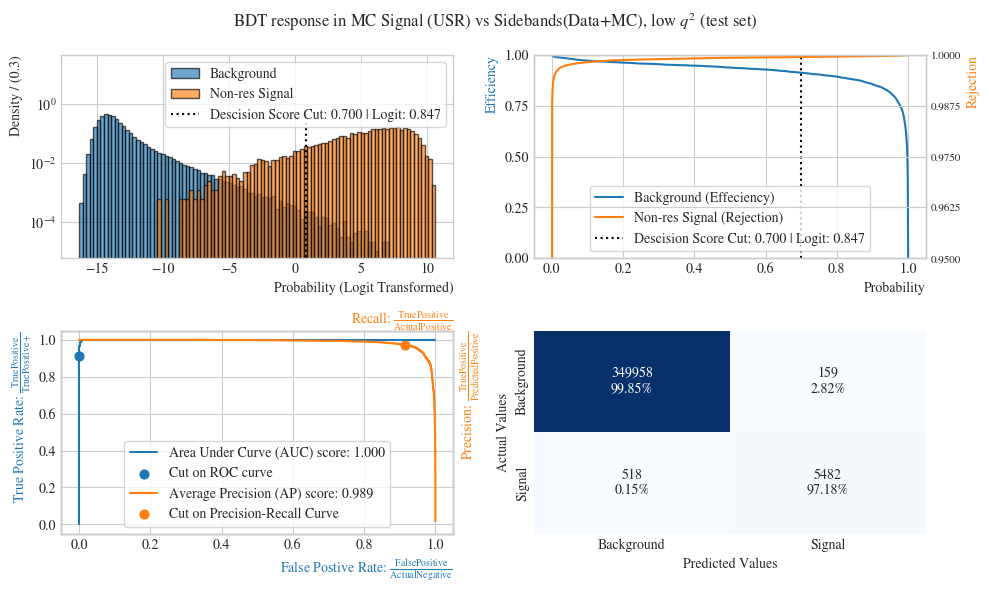

In [14]:

def MC_Sig_Vs_Bkg_SB_response_curve(input_data, tag='BDT_SB'):
    #P = plotting.plot_response(input_data=X_test_BDT1,threshold=0.7,root_tag='BDT1',test_data = True)
    P = plot_response(input_data=input_data,threshold=0.7,root_tag=tag,test_data = True)
    fig = plt.figure(figsize=(10,6))
    title=''
    P.plot_descision_scores(fig=fig,placemenent=221,title=title,legend1='Background',legend2='Non-res Signal')
    title=''
    P.Plot_efficiency_rejection(fig=fig,placemenent=222,title=title,y_range=(0.95,1),legend2='Non-res Signal ',legend1='Background ')
    P.plot_roc_curve(fig=fig,placemenent=223)
    P.plot_confusionmatrix_3x3(fig=fig,placemenent=224,legend1='Signal',legend2='Background')
    main_title = "BDT response in MC Signal (USR) vs Sidebands(Data+MC), low $q^2$ (test set)"
    fig.suptitle(main_title)
    fig.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+f"{tag}_test",bbox_inches = 'tight')

    plt.show()
    
MC_Sig_Vs_Bkg_SB_response_curve(input_data=BDT_SB_test,tag='BDT_SB_iter2')

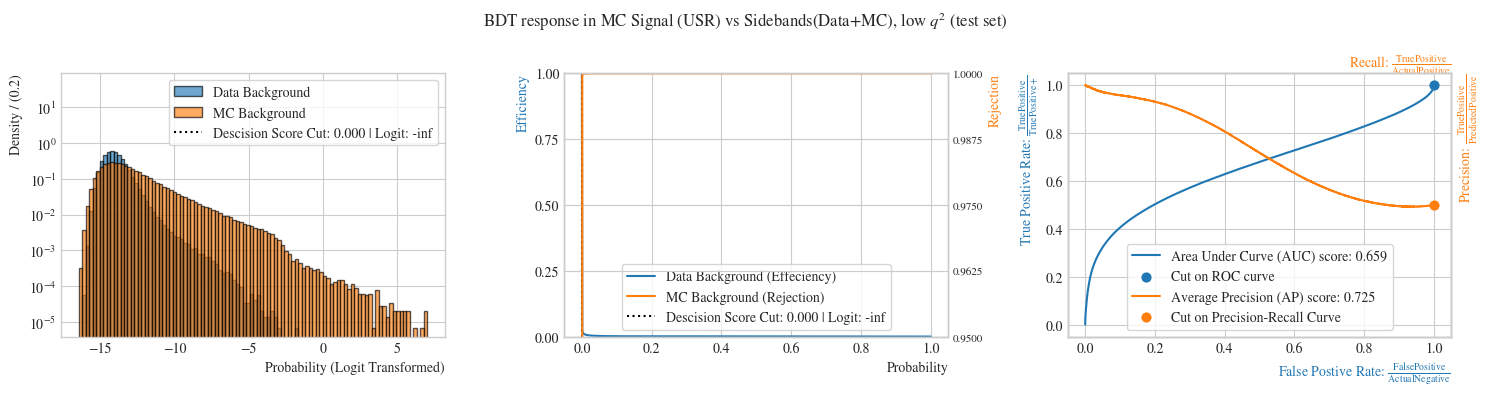

In [15]:
def MC_Sig_Vs_Bkg_SB_response_curve_TESTING_MC(input_data,tag='BDT_SB'):
    #P = plotting.plot_response(input_data=eval(f"Sig_vs_BKG_{tag.split('_')[-1]}_MC_test"),threshold=0,root_tag=tag,test_data = True,MC_TEST=True)
    P = plot_response(input_data=input_data,threshold=0,root_tag=tag,test_data = True)
    fig = plt.figure(figsize=(15,4))
    title=''
    P.plot_descision_scores(fig=fig,placemenent=131,title=title,legend2='MC Background',legend1='Data Background')
    title=''
    P.Plot_efficiency_rejection(fig=fig,placemenent=132,title=title,y_range=(0.95,1),legend2='MC Background ',legend1='Data Background ')
    P.plot_roc_curve(fig=fig,placemenent=133)
    #P.plot_confusionmatrix_3x3(fig=fig,placemenent=224,legend1='Signal',legend2='Background')
    main_title = "BDT response in MC Signal (USR) vs Sidebands(Data+MC), low $q^2$ (test set)"
    fig.suptitle(main_title)
    fig.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+f"{tag}_TESTING_MC",bbox_inches = 'tight')

    plt.show()
    
MC_Sig_Vs_Bkg_SB_response_curve_TESTING_MC(input_data = Sig_vs_BKG_SB_MC_test, tag='BDT_SB_iter2')

In [16]:
class plot_mass_shape_in_USR():
    def __init__(self,test_data:bool=False):
        self.test_data = test_data

    def plot_mass(self,fig:mpl.figure.Figure=None,placemenent:int=131, input_data: pd.core.frame.DataFrame = None, target:str = 'B_mass_Kstar_mass_closer', title:str=None,root_tag:str=None,xrange_bins:tuple=(4000,5700,85)):
        cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        PData = input_data # input_data = Data[(Data.info_sample == '300590')]

        if self.test_data == False:
            #Local Candidates
            PData_LC = PData.sort_values('P_BDT_min').groupby(['info_event_number']).tail(1).sort_index()
        else:
            PData_LC = PData

        def mass_hypotesis_predict(X):
            XX = X.copy()
    
            model = Storage.load_lgbm(key=f"{'BDT_BBbar'}/model")
            feat_idx = model.feature_name()
            X=X[feat_idx]

            X_scaled = Utils.pd_scale(Storage,X, root_tag= 'BDT_BBbar')
            BDT_scores = model.predict(X_scaled.reindex(columns=feat_idx))

            XX['mass_hypotesis'] = np.array(['BdBar' if pred > 0.5 else 'Bd' for pred in BDT_scores])
            """
            X['mass_hypotesis'] = 'NaN'
            max_select = np.argmax([X.P_BDT1_sum, X.P_BDT2_sum],axis=0)
            max_select_BDT1 = np.argmax([X.P_BDT1_Bd, X.P_BDT1_BdBar],axis=0)
            max_select_BDT2 = np.argmax([X.P_BDT2_Bd, X.P_BDT2_BdBar],axis=0)
            X['mass_hypotesis'][(max_select==0)&(max_select_BDT1==0)] = 'Bd'
            X['mass_hypotesis'][(max_select==0)&(max_select_BDT1==1)] = 'BdBar'
            X['mass_hypotesis'][(max_select==1)&(max_select_BDT2==0)] = 'Bd'
            X['mass_hypotesis'][(max_select==1)&(max_select_BDT2==1)] = 'BdBar'
            """
            return XX
            
        PData_LC_MH=mass_hypotesis_predict(PData_LC)
        PData_LC_MH_Bd=PData_LC_MH[(PData_LC_MH['mass_hypotesis']=='Bd')]


        ax_main = fig.add_subplot(placemenent)
        ax_main.axis('off')  # command for hiding the axis.
        Sub_top = inset_axes(ax_main, width="100%", height="67.5%", loc=9)
        Sub_bottom = inset_axes(ax_main, width="100%", height="27.5%", loc=8)
        Sub_top.set_xticks([])
        Sub_top.sharex(Sub_bottom)
        Sub_top.tick_params(labelbottom=False)
        Sub_top.spines['bottom'].set_visible(True)

        xrange=xrange_bins[:2]
        bins= xrange_bins[2]
        bindwidth = (xrange[1]-xrange[0])/bins
        bindwidth_str = str(float(f"{bindwidth:.1g}")).split('.')[0] if float(str(float(f"{bindwidth:.1g}")).split('.')[-1]) == 0 else str(float(f"{bindwidth:.1g}"))

        #bench, edges,_ = Sub_top.hist(PData_LC_MH_Bd.eval(f"{target}"),bins=bins,range=xrange, density=True,histtype = 'step', fill = None, label='Benchmark (NonRes Bd)',lw=1.5,color=cycle[0])
        bench, edges = np.histogram(PData_LC_MH_Bd.eval(f"{target}"),bins=bins,range=xrange,density=False)

        centers  = 0.5*(edges[1:] + edges[:-1])
        heights = []
        heights_max = []
        cut_range = [0,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
        for i in range(len(cut_range)):
            cut = cut_range[i]
            bin_hights_max ,_,_ = Sub_top.hist(PData_LC_MH_Bd.eval(f"{target}")[(PData_LC_MH_Bd.eval(f"P_{root_tag}") > cut)],bins=bins,range=xrange,density=True,histtype = 'step', fill = None, label=f"$[P_{{{root_tag}}}(B_d)+P_{{{root_tag}}}(\overline{{B}}_d)] > {cut}$",lw=1.5,color=cycle[i+1])
            bin_hights ,_ = np.histogram(PData_LC_MH_Bd.eval(f"{target}")[(PData_LC_MH_Bd.eval(f"P_{root_tag}") > cut)],bins=bins,range=xrange,density=False)

            heights_max.append(bin_hights_max)          
            heights.append(bin_hights)

        effs_iter_max = []
        effs_iter_min = []

        # For fit to linear:

        for i in range(1,len(heights)):
            bench = heights[0]
            Eff=np.divide(heights[i],bench)
            Eff_xerr=(edges[1] - edges[0] )/2
            Eff_yerr=np.sqrt(np.divide(np.multiply(Eff, np.subtract(np.ones(Eff.size), Eff)), bench)) #Binomial error
        
            Eff_yerr, centers_Eff, Eff=Eff_yerr[~np.isnan(Eff)], centers[~np.isnan(Eff)], Eff[~np.isnan(Eff)]
            
            mask_mean = (Eff_yerr)!=0
            yrr,Xrr = Eff_yerr[mask_mean],Eff[mask_mean]
            weight,weight_mask = np.divide(1,yrr**2), ~np.isnan(np.divide(1,yrr**2))

            mean = np.mean(Eff)
            mean_std = np.std(Eff)

            ## FIT LINEAR:
            def linear_fit(x,a, b):
              return a*x + b  
            Init_fit = {'a': [0,None,None,True],'b': [mean,0,1,False],} # Initial Guess, #limit1, limit2 and fix=False
            minuit_chi2_object = Utils.Chi2Regression(linear_fit, centers_Eff[mask_mean], Eff[mask_mean],Eff_yerr[mask_mean],bound=xrange) 
            iminut_initializer = Utils.iminut_value_initializer(Init_fit,linear_fit)
            minuit_chi2 = Minuit(minuit_chi2_object, *iminut_initializer.init_values(), name = iminut_initializer.names())
            minuit_chi2.errordef = Minuit.LEAST_SQUARES     # Value for likelihood fits
            iminut_initializer.limits_and_fixed(minuit_chi2)
            minuit_chi2.migrad()
            minuit_chi2.hesse() 
            if (not minuit_chi2.fmin.is_valid) :
                print("  WARNING: The Unbinned Likelihood fit DID NOT converge!!! ")   
            N_NotEmptyBin = np.sum(Eff > 0)
            Ndof_value = N_NotEmptyBin - minuit_chi2.nfit
            Prob_value_linear_fit = scipy.stats.chi2.sf(minuit_chi2.fval, Ndof_value) # The chi2 probability given N_DOF degrees of freedom  
            Sub_bottom.plot(centers_Eff, linear_fit(centers_Eff, *minuit_chi2.values[:]), color=cycle[i+1],lw=1,linestyle='-',alpha=0.7) 

            """

            ## FIT Gauss:
            def gauss_pdf(x, mu, sigma, C):
                # Gaussian
                return (1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)) + C
            Init_fit = {'mu': [5200,4000,6000,False],'sigma': [50,None,None,False],'C': [0,0,1,False]}            
            minuit_chi2_object = Utils.Chi2Regression(gauss_pdf, centers_Eff[mask_mean], Eff[mask_mean],Eff_yerr[mask_mean],bound=xrange) 
            iminut_initializer = Utils.iminut_value_initializer(Init_fit,gauss_pdf)
            minuit_chi2 = Minuit(minuit_chi2_object, *iminut_initializer.init_values(), name = iminut_initializer.names())
            minuit_chi2.errordef = Minuit.LEAST_SQUARES     # Value for likelihood fits
            iminut_initializer.limits_and_fixed(minuit_chi2)
            minuit_chi2.migrad()
            minuit_chi2.hesse() 
            if (not minuit_chi2.fmin.is_valid) :
                print("  WARNING: The Unbinned Likelihood fit DID NOT converge!!! ")   
            N_NotEmptyBin = np.sum(Eff > 0)
            Ndof_value = N_NotEmptyBin - minuit_chi2.nfit
            Prob_value_gauss_fit = scipy.stats.chi2.sf(minuit_chi2.fval, Ndof_value) # The chi2 probability given N_DOF degrees of freedom  
            
            Sub_bottom.plot(centers_Eff, gauss_pdf(centers_Eff, *minuit_chi2.values[:]), color=cycle[i+1],lw=1,linestyle='-',alpha=0.7) 
            """     

            label_eff = f'P(Constant): {Prob_value_linear_fit:.3f}'#, P(Gauss): {Prob_value_gauss_fit:.3f}'
            Sub_bottom.errorbar(centers_Eff, Eff,yerr=Eff_yerr, xerr=Eff_xerr,fmt="none",label=label_eff,color=cycle[i+1])
            
            if i == 1:
                pd.DataFrame({'centers_Eff':centers_Eff,'Eff': Eff, 'Eff_yerr': Eff_yerr }).to_pickle('test.pkl')

            effs_iter_max.append(np.max(Eff))
            effs_iter_min.append(np.min(Eff))

        Sub_top.set_title(title)
        Sub_top.set_ylim(0,np.max(heights_max)*1.35)

        Sub_top.legend(loc='upper left',frameon=True)
        Sub_bottom.set_xlabel(f"$m(B_{{K^* \t{{closer}}}})$ $[MeV]$",loc='right')

        Sub_top.set_ylabel(f"Density / ({bindwidth_str})",loc='top')
        Sub_bottom.set_ylabel(f"Efficiency",loc='top')
        
        Sub_bottom.set_ylim(np.max([0.0,np.min(effs_iter_min)*0.5]),np.min([1.1,np.max(effs_iter_max)*1.5]))
        Sub_bottom.legend(loc = 'best', frameon=True,fontsize=6.8,ncol=2)
        Sub_top.ticklabel_format(axis="y", style="sci", scilimits=(0,0))




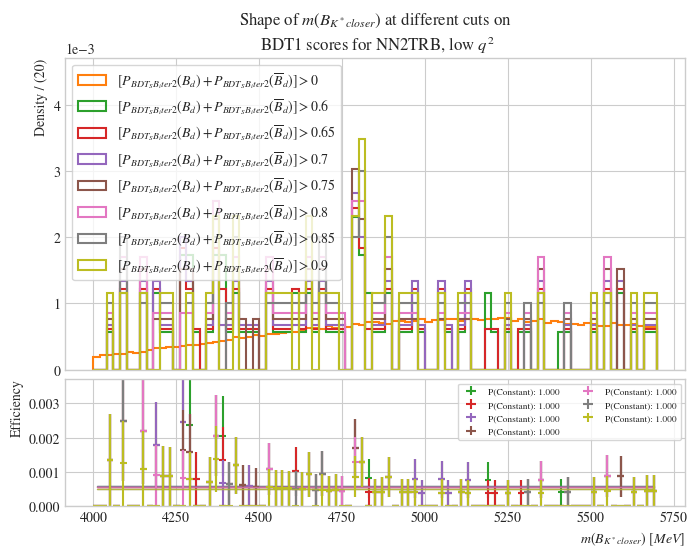

In [17]:
Test__ = one_BDT_predicter(Storage,X_target = pd.concat([BKG_SB,BKG_MC.query(Utils.selection_cuts()['MC2'])]),root_tag='BDT_SB_iter2')
#Test__SR = Predict(Storage,X_target = pd.concat([BKG_SR,BKG_MC.query(Utils.selection_cuts()['MC2'])]),root_tag='BDT_SR')

def plot_mass_shape_in_USR_wrapper():
    P = plot_mass_shape_in_USR(test_data=True)

    fig = plt.figure(figsize=(8,6))
    title='Shape of $m(B_{{K^* \t{{closer}}}})$ at different cuts on \n'+r" BDT1 scores for NN2TRB, low $q^2$"
    P.plot_mass(fig=fig,placemenent=111, input_data = Test__, target = 'B_mass_Kstar_mass_closer', title=title, root_tag='BDT_SB_iter2')
 
    #title='Shape of $m(B_{{K^* \t{{closer}}}})$ at different cuts on \n'+r" BDT2 scores for NN2TRB, low $q^2$"
    #P.plot_mass(fig=fig,placemenent=122, input_data = Test__SR, target = 'B_mass_Kstar_mass_closer', title=title, root_tag='BDT_SR')
    plt.savefig(config['PATHS']['figure_save']+"_BDT_SB_iter2_"+f"_TESTING_leak",bbox_inches = 'tight')


    plt.show() 

plot_mass_shape_in_USR_wrapper()

In [ ]:
import sklearn.inspection
from sklearn import preprocessing, model_selection, metrics

class feature_importance2:
    def __init__(self,data:pd.DataFrame, root_tag:str):
        self.data = data.copy()
        self.root_tag = root_tag
        self.lgbm_model = None
        self.features = None
        self.load_lightgbm_model_and_set_features()
        self.rets = pd.DataFrame(index = self.features)

    def load_lightgbm_model_and_set_features(self) -> None:
        self.lgbm_model = Storage.load_lgbm(key=f"{self.root_tag}/model")
        self.features = list(self.lgbm_model.feature_name())

    def SHAP(self,X_data:pd.core.frame.DataFrame, label:str) -> None:
        print(f'Init SHAP importances ({label})...')

        X_scaled = Utils.pd_scale(Storage,X_data.copy()[self.features], root_tag= self.root_tag)
        lgbm_shap = self.lgbm_model.predict(X_scaled.reindex(columns=self.features), pred_contrib=True)
        df = pd.DataFrame(columns=['SHAP_'+label],index= self.features, data= np.abs(lgbm_shap[:,:-1]).mean(0))
        self.rets = pd.concat([self.rets,df],axis=1)
        print('Done with SHAP importances')
    
    def Native_lgbm(self, label:str) -> None:
        print(f'Init Native LGBM importances ({label})...')
        
        native_importance = self.lgbm_model.feature_importance()
        native_indices = np.argsort(native_importance)
        Native_importance = pd.DataFrame({'features': np.array(self.features)[native_indices][::-1], 'native_values': native_importance[native_indices][::-1]})
        
        df = pd.DataFrame(columns=['Native_'+label],index= self.features, data= native_importance)
        self.rets = pd.concat([self.rets,df],axis=1)
        print('Done with Native LGBM importances')

    def Permutation(self,X_data:pd.core.frame.DataFrame, y_data:pd.core.frame.DataFrame, label:str, scorer:sklearn.metrics._scorer._PredictScorer, N_repeats:int) -> None:
        print(f'Init Permutation importances ({label})...')
        AUC_score=sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score,greater_is_better=True)
        RMSE_score = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,squared=False,greater_is_better=False)

        PERM_score = sklearn.inspection.permutation_importance(self.lgbm_model, X_data.copy()[self.features], y_data.copy(), n_repeats=N_repeats, random_state=42,n_jobs=1,scoring=scorer)
        df = pd.DataFrame(columns=['perm_'+label],index= self.features, data= PERM_score.importances_mean)
        self.rets = pd.concat([self.rets,df],axis=1)
        print('Done with Permutation importances.')

    def permutation_importance(self,X_data:pd.DataFrame,y_data:pd.DataFrame,label:str, scorer, N_repeats:int=1, N_jobs:int = 1):
        print(f'Init Permutation importances ({label})...')

        #X_scaled = Utils.pd_scale(Storage,X_data, root_tag= self.root_tag)
        BDT_scores = self.lgbm_model.predict(X_data.reindex(columns=self.features))
        original_score = scorer(y_data,BDT_scores)

        importances = {'feature': [], f"perm_{label}": []}

        # For each feature
        for feature in self.features:
            mean = []
            for i in range(5):
            # Create a copy of the test set with the current feature shuffled
                X_test_shuffled = X_data.copy()
                X_test_shuffled[feature] = np.random.permutation(X_test_shuffled[feature])
                
                BDT_scores = self.lgbm_model.predict(X_test_shuffled)

                # Calculate the score of the shuffled test set
                shuffled_score = scorer(y_data,BDT_scores)
                
                # Calculate the feature importance as the difference in accuracy
                mean.append(shuffled_score - original_score)

            feature_importance = np.mean(np.array(mean))
            importances[f"perm_{label}"].append(feature_importance)
            importances['feature'].append(feature)


        df = pd.DataFrame(importances)
        df = df.set_index('feature')
        self.rets = pd.concat([self.rets,df],axis=1)
        print('Done with Permutation importances.')

    def get_Frame(self) -> pd.DataFrame:
        return self.rets

In [66]:
def add_BDT_score(data:pd.core.frame.DataFrame,root_tag: str = 'BDT_BBbar') -> pd.core.frame.DataFrame:
    """ Applis BDT scores to the data using the BDT model from model_root.
    A new columnt of BDT scores are applied.

    Args:
        data (pd.core.frame.DataFrame): Input data
        model_root (str, optional): BDT model string tag from HDF5-storage. Defaults to 'BDT_BBbar'.

    Returns:
        pd.core.frame.DataFrame: out put data with added columns: BDT scores
    """
    model = Storage.load_lgbm(key=f"{root_tag}/model")
    feat_idx = model.feature_name()
    data=data[feat_idx]

    data_scaled = Utils.pd_scale(Storage,data, root_tag= root_tag)
    BDT_scores = model.predict(data_scaled.reindex(columns=feat_idx))

    data[f"P_{root_tag}"] = BDT_scores
    return data

test = add_BDT_score(data=Sig_vs_BKG_SB_MC_test)


In [68]:
test['mass_hypotesis'] = ['BDbar' if x >= 0.5 else 'Bd' for x in test[f"P_{'BDT_BBbar'}"]]
test

dR_diElectron_Kstar  dPhi_positron_electron  BeeKst_y  \
0                  0.754891                0.141563 -0.911252   
1                  0.053577                0.089566 -0.996197   
2                  0.515530                0.089566 -0.761575   
3                  0.087875                0.089566 -0.924491   
4                  1.020077                0.089566 -1.016101   
...                     ...                     ...       ...   
657543             0.323836                0.094211 -0.389630   
657544             0.505512                0.094211 -0.822441   
657545             0.473256                0.094211 -0.292281   
657546             0.357692                0.094211 -0.239325   
657547             0.616528                0.094211 -0.315068   

        Lxy_significance_over_B_chi2  BeeKst_a0_maxSumPt2  diElectron_iso_m00  \
0                           0.003716             0.023226        24132.402344   
1                           0.193509             0.082633            0.000000   
2                          -0.349970             0.037683         9961.702148   
3                          -0.015205             0.080830         7982.527344   
4                           0.045234             0.085057         9961.702148   
...                              ...                  ...                 ...   
657543                      0.033557             0.026966         6365.682129   
657544                     -0.142871             0.034622         6365.682129   
657545                      0.070228             0.029922         6365.682129   
657546                      0.180507             0.036248         6365.682129   
657547                      0.047949             0.028440         6365.682129   

        diMeson_Kpi_piK_mass_closer_PDG  BeeKst_diElectron_vtx_y_err  \
0                            976.299072                     0.173211   
1                            777.713257                     0.228017   
2                           1056.037720                     0.228017   
3                            847.781921                     0.228017   
4                            933.064880                     0.228017   
...                                 ...                          ...   
657543                       787.261963                     0.168544   
657544                       919.379883                     0.168544   
657545                       873.889221                     0.168544   
657546                       815.108643                     0.168544   
657547                       786.080383                     0.168544   

        BeeKst_diElectron_pT    track1_pT  ...  positron_OQ  \
0               24001.197266   502.500732  ...      4718608   
1               22394.509766  1979.174561  ...           24   
2               22394.509766   846.494751  ...           24   
3               22394.509766   642.917236  ...           24   
4               22394.509766   503.108185  ...           24   
...                      ...          ...  ...          ...   
657543          39626.753906   641.348633  ...       524288   
657544          39626.753906   556.719116  ...       524288   
657545          39626.753906   556.719116  ...       524288   
657546          39626.753906   556.719116  ...       524288   
657547          39626.753906   641.348633  ...       524288   

        positron_ptvarcone40_TightTTVALooseCone_pt1000  tracks_dEdx_sum  \
0                                         34913.839844         2.026447   
1                                         25923.181641         1.627268   
2                                         25923.181641         1.662343   
3                                         25923.181641         2.106670   
4                                         25923.181641         1.607375   
...                                                ...              ...   
657543                                    18085.660156         2.171543   
657544                          

In [36]:
def apply_local_candidate(data:pd.core.frame.DataFrame, apply_on_column:str = 'P_BDT_min', is_test:bool = True) -> pd.core.frame.DataFrame:
    """ Applies local candidate selection based on the "apply_on_column". Default is P_BDT_min since we want to find the largest of the minimum.

    Args:
        data (pd.core.frame.DataFrame): Data on which we want to apply local candidate selection
        apply_on_column (str, optional): Column we sort on. Defaults to 'P_BDT_min'.
        is_test (bool, optional): If this is a test, we do not sort. Defaults to True.

    Returns:
        pd.core.frame.DataFrame: Dublicates are removed.
    """
    if is_test == False:
        assert 'info_event_number' in list(data.columns), 'info_event_number is not in "data"..'
        return data.sort_values('P_BDT_min').groupby(['info_event_number']).tail(1).sort_index()
    else:
        return data

def add_BDT_score(data:pd.core.frame.DataFrame,root_tag: str = 'BDT_BBbar') -> pd.core.frame.DataFrame:
    """ Applis BDT scores to the data using the BDT model from model_root.
    A new columnt of BDT scores are applied.

    Args:
        data (pd.core.frame.DataFrame): Input data
        model_root (str, optional): BDT model string tag from HDF5-storage. Defaults to 'BDT_BBbar'.

    Returns:
        pd.core.frame.DataFrame: out put data with added columns: BDT scores
    """
    model = Storage.load_lgbm(key=f"{root_tag}/model")
    feat_idx = model.feature_name()
    data_reduced=data[feat_idx]

    data_scaled = Utils.pd_scale(Storage,data_reduced, root_tag= root_tag)
    BDT_scores = model.predict(data_scaled.reindex(columns=feat_idx))

    data[f"P_{root_tag}"] = BDT_scores
    return data
    

def bkg_mass_shape_metric(input_data: pd.core.frame.DataFrame = None, target:str = 'B_mass_Kstar_mass_closer',root_tag:str=None,xrange_bins:tuple=(4000,5700,85)) -> float:
    Data = input_data.copy()

    ## FIT LINEAR:
    def linear_fit(x,a, b):
        return a*x + b  

    Data = apply_local_candidate(Data, apply_on_column='P_BDT_min', is_test=True)
    Data = add_BDT_score(Data, root_tag = 'BDT_BBbar')
    Data['mass_hypotesis'] = ['BDbar' if x >= 0.5 else 'Bd' for x in Data[f"P_{'BDT_BBbar'}"]]

    Data=Data[(Data['mass_hypotesis']=='Bd')]


    xrange=xrange_bins[:2]
    bins= xrange_bins[2]
    bindwidth = (xrange[1]-xrange[0])/bins

    bench, edges = np.histogram(Data.eval(f"{target}"),bins=bins,range=xrange,density=False)

    centers  = 0.5*(edges[1:] + edges[:-1])
    heights = []

    cut_range = [0,0.6,0.65,0.7,0.75,0.8,0.85,0.9]

    for i in range(len(cut_range)):
        cut = cut_range[i]
        bin_hights ,_ = np.histogram(Data.eval(f"{target}")[(Data.eval(f"P_{root_tag}") > cut)],bins=bins,range=xrange,density=False)

        heights.append(bin_hights)

    res_lin = []

    for i in range(1,len(heights)):
        bench = heights[0]
        Eff=np.divide(heights[i],bench)
        Eff_yerr=np.sqrt(np.divide(np.multiply(Eff, np.subtract(np.ones(Eff.size), Eff)), bench)) #Binomial error

        Eff_yerr, centers_Eff, Eff=Eff_yerr[~np.isnan(Eff)], centers[~np.isnan(Eff)], Eff[~np.isnan(Eff)]
        
        mask_mean = (Eff_yerr)!=0
        mean = np.mean(Eff)

        Init_fit = {'a': [0,None,None,True],'b': [mean,0,1,False],} # Initial Guess, #limit1, limit2 and fix=False
        minuit_chi2_object = Utils.Chi2Regression(linear_fit, centers_Eff[mask_mean], Eff[mask_mean],Eff_yerr[mask_mean],bound=xrange) 
        iminut_initializer = Utils.iminut_value_initializer(Init_fit,linear_fit)
        minuit_chi2 = Minuit(minuit_chi2_object, *iminut_initializer.init_values(), name = iminut_initializer.names())
        minuit_chi2.errordef = Minuit.LEAST_SQUARES     # Value for likelihood fits
        iminut_initializer.limits_and_fixed(minuit_chi2)
        minuit_chi2.migrad()
        minuit_chi2.hesse()
        if (not minuit_chi2.fmin.is_valid) :
            print("  WARNING: fit DID NOT converge!!! ") 
        N_NotEmptyBin = np.sum(Eff > 0)
        Ndof_value = N_NotEmptyBin - minuit_chi2.nfit
        res_lin.append(scipy.stats.chi2.sf(minuit_chi2.fval, Ndof_value)) # The chi2 probability given N_DOF degrees of freedom  

    return np.mean(np.array(res_lin))

def mass_sculping_feature_importance(X_data = None, root_tag:str = 'BDT_SB', iterations:int =1):
    Data = X_data.copy()
    model = Storage.load_lgbm(key=f"{root_tag}/model")
    feat_idx = model.feature_name()

    Data = add_BDT_score(Data, root_tag = root_tag)
    # base score, the lower the better:
    base_score = bkg_mass_shape_metric(input_data = Data, target = 'B_mass_Kstar_mass_closer', root_tag=root_tag)
    # Create an empty list to store the feature importances
    importances = []

    # For each feature
    for feature in list(feat_idx):
        mean = []
        for i in range(iterations):
            # Create a copy of the test set with the current feature shuffled
            X_test_shuffled = Data.copy()
            X_test_shuffled[feature] = np.random.permutation(X_test_shuffled[feature]) 

            X_test_shuffled = add_BDT_score(X_test_shuffled, root_tag = root_tag)        
            # Calculate the accuracy of the shuffled test set
            mean.append(bkg_mass_shape_metric(input_data = X_test_shuffled, target = 'B_mass_Kstar_mass_closer', root_tag=root_tag))
        new_score = np.mean(np.array(mean))  

        importances.append({'index': feature,
                    'Mass_Sculping': new_score - base_score })
    
    perm_df = pd.DataFrame(importances).set_index('index')
    
    return perm_df

In [81]:
X_target = pd.concat([BKG_SB,BKG_MC.query(Utils.selection_cuts()['MC2'])])
Test1 = mass_sculping_feature_importance(X_data = X_target, root_tag= 'BDT_SB_iter1')

feature_imp_pd.merge(Test1, how='left',left_index=True,right_index=True)

test1
test2
BeeKst_a0xy_maxSumPt2
0.9999599194617997
BeeKst_a0xy_maxSumPt2_err
0.9999599194617997
BeeKst_a0xy_minA0
0.9999599194617997
BeeKst_a0xy_minA0_err
0.9999599194617997
BeeKst_a0xy_minZ0
0.9999599194617997


In [88]:
Test1

score
index                           
BeeKst_a0xy_maxSumPt2        0.0
BeeKst_a0xy_maxSumPt2_err    0.0
BeeKst_a0xy_minA0            0.0
BeeKst_a0xy_minA0_err        0.0
BeeKst_a0xy_minZ0            0.0

In [14]:
import sklearn.inspection
from sklearn import preprocessing, model_selection, metrics

class Feature_Importance_plots():
    def __init__(self,N:int=None):
        self.N = N

    def plot_shap_mean(self,fig,placemenent:int,importance_data1=None,importance_data2=None, label1:str =None,label2:str=None):

        ax_shap = fig.add_subplot(placemenent)

        P1 = importance_data1
        if (importance_data2).all() == None:
            P2 = P1
        else:
            P2 = importance_data2.reindex(P1.index)

        if self.N != None:
            P1 = P1.iloc[len(P1)-self.N:]
            P2 = P2.iloc[len(P2)-self.N:]

        x = np.arange(len(P1))
        width = 0.4
      
        ax_shap.barh(x+width/2, P1.values, width,label=label1,alpha=1)
        if (importance_data2 != None).all():
            ax_shap.barh(x-width/2, P2.values, width,label=label2,alpha=1)
        ax_shap.set(title='SHAP Feature Importance',xlabel='mean(|SHAP| value)\n(average impact on model output magnitude)')
        ax_shap.set(yticks=x, yticklabels=list(P1.index), ylim=[2*width - 1-width, len(P1)])
        ax_shap.legend(loc = 'lower right', framealpha =0.95)    
        ax_shap.tick_params(axis='y', which='major', labelsize=7)
    
    def plot_shap_sum(self,fig,placemenent:int,importance_data1=None,importance_data2=None, label1:str =None,label2:str=None):

        ax_shap = fig.add_subplot(placemenent)

        P1 = importance_data1
        if (importance_data2).all() == None:
            P2 = P1
        else:
            P2 = importance_data2.reindex(P1.index)

        if self.N != None:
            P1 = P1.iloc[len(P1)-self.N:]
            P2 = P2.iloc[len(P2)-self.N:]

        x = np.arange(len(P1))
        width = 0.4
      
        ax_shap.barh(x+width/2, P1.values, width,label=label1,alpha=1)
        if (importance_data2 != None).all():
            ax_shap.barh(x-width/2, P2.values, width,label=label2,alpha=1)
        ax_shap.set(title='SHAP Feature Importance',xlabel='sum(SHAP value)\n(summed impact on model)')
        ax_shap.set(yticks=x, yticklabels=list(P1.index), ylim=[2*width - 1-width, len(P1)])
        ax_shap.legend(loc = 'lower right', framealpha =0.95)    
        ax_shap.tick_params(axis='y', which='major', labelsize=7)

    def plot_permute(self,fig=None,placemenent=132,importance_data1=None,importance_data2=None, label1:str =None,label2:str=None):
        ax_permute = fig.add_subplot(placemenent)

        P1 = importance_data1
        if (importance_data2 == None):
            P2 = P1
        else:
            P2 = importance_data2.reindex(P1.index)

        if self.N != None:
            P1 = P1.iloc[len(P1)-self.N:]
            P2 = P2.iloc[len(P2)-self.N:]

        x = np.arange(len(P1))
        width = 0.4
      
        ax_permute.barh(x+width/2, P1.values, width,label=label1,alpha=1)
        if (importance_data2 != None):
            ax_permute.barh(x-width/2, P2.values, width,label=label2,alpha=1)
        ax_permute.set(title='Permutated Feature Importance',xlabel='Relative importance')
        ax_permute.set(yticks=x, yticklabels=list(P1.index), ylim=[2*width - 1-width, len(P1)])
        ax_permute.legend(loc = 'lower right', framealpha =0.95)    
        ax_permute.tick_params(axis='y', which='major', labelsize=7)  

    def plot_native(self,fig=None,placemenent=133,importance_data=None):
        ax_native = fig.add_subplot(placemenent)
        native = importance_data

        if self.N != None:
            native = native.iloc[len(native)-self.N:]

        x = np.arange(len(native))
        width = 0.4
        ax_native.barh(x, native.values)
        ax_native.set(yticks=x, yticklabels=list(native.index), ylim=[2*width - 1-width, len(native)])
        ax_native.set(title='LightGBM Feature Importance',xlabel='Impact on model (Native lightGBM)')
        ax_native.tick_params(axis='y', which='major', labelsize=7)
    
    def plot_mass_sculp(self,fig=None,placemenent=133,importance_data=None, title = ""):
        ax_mass_sculp = fig.add_subplot(placemenent)
        data = importance_data

        if self.N != None:
            data = data.iloc[len(data)-self.N:]

        x = np.arange(len(data))
        width = 0.4
        ax_mass_sculp.barh(x, data.values)
        ax_mass_sculp.set(yticks=x, yticklabels=list(data.index), ylim=[2*width - 1-width, len(data)])
        ax_mass_sculp.set(title=title,xlabel=r'$\chi^2$ performance')
        ax_mass_sculp.tick_params(axis='y', which='major', labelsize=7)


In [19]:
import sklearn.inspection
from sklearn import preprocessing, model_selection, metrics

class feature_importance:
    def __init__(self,data:pd.DataFrame, root_tag:str):
        self.data = data.copy()
        self.root_tag = root_tag
        self.lgbm_model = None
        self.features = None
        self.load_lightgbm_model_and_set_features()
        self.rets = pd.DataFrame(index = self.features)

    def load_lightgbm_model_and_set_features(self) -> None:
        self.lgbm_model = Storage.load_lgbm(key=f"{self.root_tag}/model")
        self.features = list(self.lgbm_model.feature_name())

    def SHAP(self,X_data:pd.core.frame.DataFrame, label:str) -> None:
        print(f'Init SHAP importances ({label})...')

        X_scaled = Utils.pd_scale(Storage,X_data.copy()[self.features], root_tag= self.root_tag)
        lgbm_shap = self.lgbm_model.predict(X_scaled.reindex(columns=self.features), pred_contrib=True)
        df1 = pd.DataFrame(columns=['SHAP_sum_'+label],index= self.features, data= (lgbm_shap[:,:-1]).sum(0))
        df2 = pd.DataFrame(columns=['SHAP_mean_'+label],index= self.features, data= np.abs(lgbm_shap[:,:-1]).mean(0))
        self.rets = pd.concat([self.rets,df1,df2],axis=1)
        print('Done with SHAP importances')
    
    def Native_lgbm(self, label:str) -> None:
        print(f'Init Native LGBM importances ({label})...')
        
        native_importance = self.lgbm_model.feature_importance()
        native_indices = np.argsort(native_importance)
        Native_importance = pd.DataFrame({'features': np.array(self.features)[native_indices][::-1], 'native_values': native_importance[native_indices][::-1]})
        
        df = pd.DataFrame(columns=['Native_'+label],index= self.features, data= native_importance)
        self.rets = pd.concat([self.rets,df],axis=1)
        print('Done with Native LGBM importances')

    def Permutation(self,X_data:pd.core.frame.DataFrame, y_data:pd.core.frame.DataFrame, label:str, scorer:sklearn.metrics._scorer._PredictScorer, N_repeats:int) -> None:
        print(f'Init Permutation importances ({label})...')
        AUC_score=sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score,greater_is_better=True)
        RMSE_score = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,squared=False,greater_is_better=False)

        PERM_score = sklearn.inspection.permutation_importance(self.lgbm_model, X_data.copy()[self.features], y_data.copy(), n_repeats=N_repeats, random_state=42,n_jobs=1,scoring=scorer)
        df = pd.DataFrame(columns=['perm_'+label],index= self.features, data= PERM_score.importances_mean)
        self.rets = pd.concat([self.rets,df],axis=1)
        print('Done with Permutation importances.')

    def permutation_importance(self,X_data:pd.DataFrame,y_data:pd.DataFrame, label:str, scorer, sample:int = -1, N_repeats:int=1, N_jobs:int = 1):
        print(f'Init Permutation importances ({label})...')

        if sample == -1:
            X_data = X_data.copy()
            y_data = y_data.copy()

        else:
            X_data = X_data.copy()
            y_data = y_data.copy()

            X_data_idx = X_data.reset_index(drop=True).sample(sample).index

            X_data = X_data.reset_index(drop=True).loc[X_data_idx]
            y_data = y_data.reset_index(drop=True).loc[X_data_idx]


        #X_scaled = Utils.pd_scale(Storage,X_data, root_tag= self.root_tag)
        BDT_scores = self.lgbm_model.predict(X_data.reindex(columns=self.features))
        original_score = scorer(y_data,BDT_scores)

        importances = {'feature': [], f"perm_{label}": []}

        # For each feature
        for feature in self.features:
            mean = []
            for i in range(5):
            # Create a copy of the test set with the current feature shuffled
                X_test_shuffled = X_data.copy()
                X_test_shuffled[feature] = np.random.permutation(X_test_shuffled[feature])
                
                BDT_scores = self.lgbm_model.predict(X_test_shuffled)

                # Calculate the score of the shuffled test set
                shuffled_score = scorer(y_data,BDT_scores)
                
                # Calculate the feature importance as the difference in accuracy
                mean.append(shuffled_score - original_score)

            feature_importance = np.mean(np.array(mean))
            importances[f"perm_{label}"].append(feature_importance)
            importances['feature'].append(feature)


        df = pd.DataFrame(importances)
        df = df.set_index('feature')
        self.rets = pd.concat([self.rets,df],axis=1)
        print('Done with Permutation importances.')

    def get_Frame(self) -> pd.DataFrame:
        return self.rets



In [20]:
def AUC_score(y_truth, y_pred):
    fpr, tpr, _ = metrics.roc_curve(list(y_truth), list(y_pred))                 # False/True Positive Rate for our model
    auc_score = metrics.auc(fpr,tpr) 
    return auc_score

if __name__ == "__main__":

    get_importance = feature_importance(data=BDT_SB_test,root_tag='BDT_SB_iter2')
    get_importance.Native_lgbm(label='test')
    get_importance.SHAP(X_data=Sig_vs_BKG_SB_splits['X_train_scaled'].sample(200000),label='train')
    get_importance.SHAP(X_data=Sig_vs_BKG_SB_splits['X_test_scaled'].sample(200000),label='test')
    #get_importance.permutation_importance(Sig_vs_BKG_SB_splits['X_test_scaled'],Sig_vs_BKG_SB_splits['y_test'],scorer=AUC_score,label='test',sample=200000)
    #get_importance.permutation_importance(Sig_vs_BKG_SB_splits['X_train_scaled'],Sig_vs_BKG_SB_splits['y_train'],scorer=AUC_score,label='train',sample=200000)

    #get_importance.Permutation(X_data=Sig_vs_BKG_SB_splits['X_train_scaled'][:100],y_data=Sig_vs_BKG_SB_splits['y_train'][:100],label='train',scorer=AUC_score,N_repeats=10)
    #get_importance.Permutation(X_data=Sig_vs_BKG_SB_splits['X_test_scaled'][:100],y_data=Sig_vs_BKG_SB_splits['y_test'][:100],label='test',scorer=AUC_score,N_repeats=10)

feature_imp_pd = get_importance.get_Frame()
Storage.write_pd(key='BDT_SB_iter2_Feature_importance', df=feature_imp_pd, overwrite=True)

Init Native LGBM importances (test)...
Done with Native LGBM importances
Init SHAP importances (train)...
Done with SHAP importances
Init SHAP importances (test)...
Done with SHAP importances


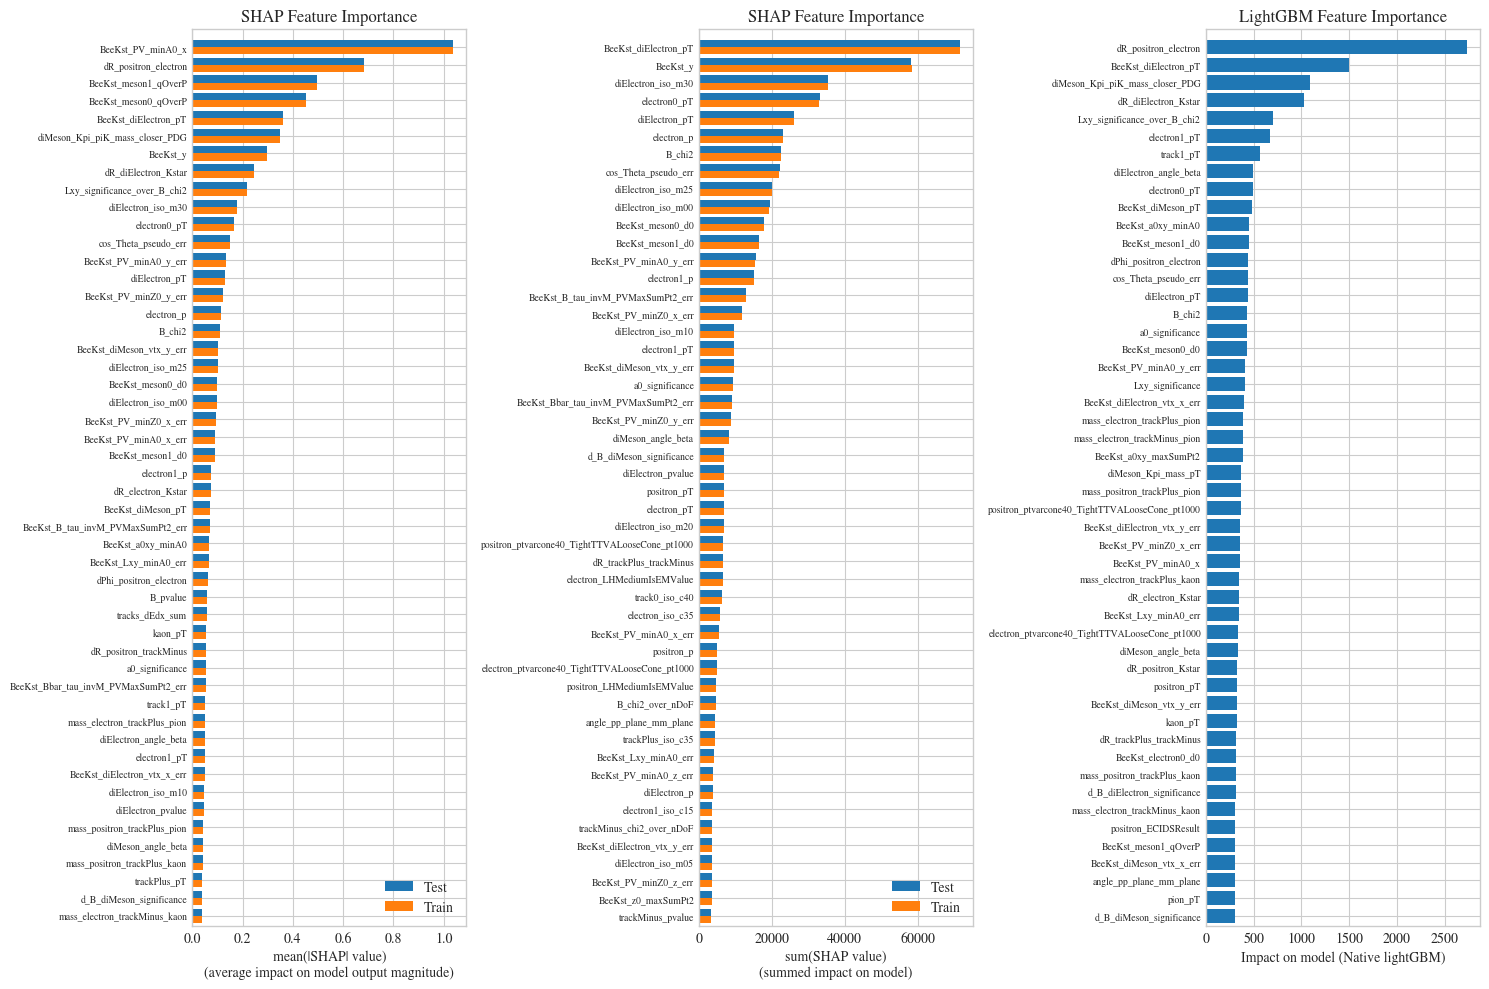

In [23]:
def feature_importance_plots():

    P=Feature_Importance_plots(N=50)

    fig = plt.figure(figsize=(15,10))
    P.plot_shap_mean(fig=fig,placemenent=131,importance_data1= feature_imp_pd.SHAP_mean_test.sort_values(), importance_data2 = feature_imp_pd.SHAP_mean_train.sort_values(), label1 = 'Test', label2 = 'Train')
    P.plot_shap_sum(fig=fig,placemenent=132,importance_data1= feature_imp_pd.SHAP_sum_test.sort_values(), importance_data2 = feature_imp_pd.SHAP_sum_train.sort_values(), label1 = 'Test', label2 = 'Train')

    #P.plot_permute(fig=fig,placemenent=132,importance_data1= (-1*feature_imp_pd.perm_test).sort_values(), label1 = 'Test', label2 = 'Train')
    P.plot_native(fig=fig,placemenent=133,importance_data = feature_imp_pd.Native_test.sort_values())
    #P.plot_neg_permute(fig=fig,placemenent=133)
    plt.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+"_BDT_SB_iter2_Feature_importances.pdf")
    plt.show()

feature_importance_plots()

In [24]:
Sig_vs_BKG_SR = pd.concat([SIG_MC,BKG_SR,BKG_MC.query(Utils.selection_cuts()['MC2'])])
Sig_vs_BKG_SR_MC_test = pd.concat([MC_tests['SR'],MC_tests['MC']])
Sig_vs_BKG_SR_splits = train_test_split_stratified(Sig_vs_BKG_SR)

Utils.fit_scaler_to_train(Storage,Sig_vs_BKG_SR_splits['X_train'][features],root_tag='BDT_SR_iter2')
Sig_vs_BKG_SR_splits['X_train_scaled'] = Utils.pd_scale(Storage,Sig_vs_BKG_SR_splits['X_train'][features], root_tag= 'BDT_SR_iter2', target_tag = 'X_train')
Sig_vs_BKG_SR_splits['X_test_scaled'] = Utils.pd_scale(Storage,Sig_vs_BKG_SR_splits['X_test'][features], root_tag= 'BDT_SR_iter2', target_tag = 'X_test')


In [25]:
%%capture --no-stdout

def Run_tuner(X_,y_,Storage=Storage,root_tag='BDT_SR'):

    assert str(type(Storage).__module__) == "Storage.Global", "Input Storage is not a correct global storage initialized from the HDF5_IO-function"

    np.random.seed(42)
    #print(f"Training LGBM with {Storage.read_pd(key=f"{root_tag}/X_train").shape[1]} features")
    tuner = verstack.LGBMTuner(metric = 'log_loss',trials=100, visualization = False, seed = 42,verbosity=1)
    
    tuner.fit(X=X_,y=y_.astype(int).squeeze())

    Storage.write_pd(key=f"{root_tag}/tuner", df = tuner.study.trials_dataframe(attrs=('number', 'value', 'params', 'state','intermediate_values'),multi_index=True),overwrite=True)
    Storage.write_pd(key=f"{root_tag}/tuner_param_imp", df = pd.DataFrame([dict(optuna.importance.get_param_importances(tuner.study).items())]).T.rename(columns={0:'value'}),overwrite=True)
    Storage.save_lgbm(key=f"{root_tag}/model",tuner=tuner, feature_names = list(X_.columns), overwrite=True)

    print('Done with training model')
    return tuner

#tuner = Run_tuner(X_=Sig_vs_BKG_SR_splits['X_train_scaled'],y_=Sig_vs_BKG_SR_splits['y_train'],root_tag='BDT_SR_iter1')


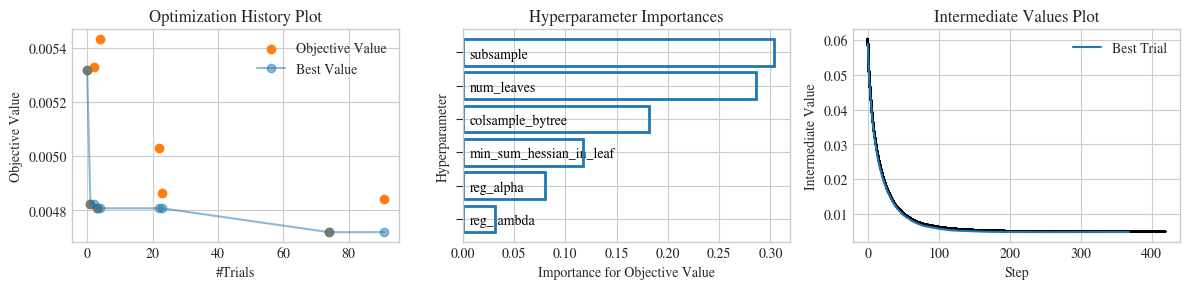

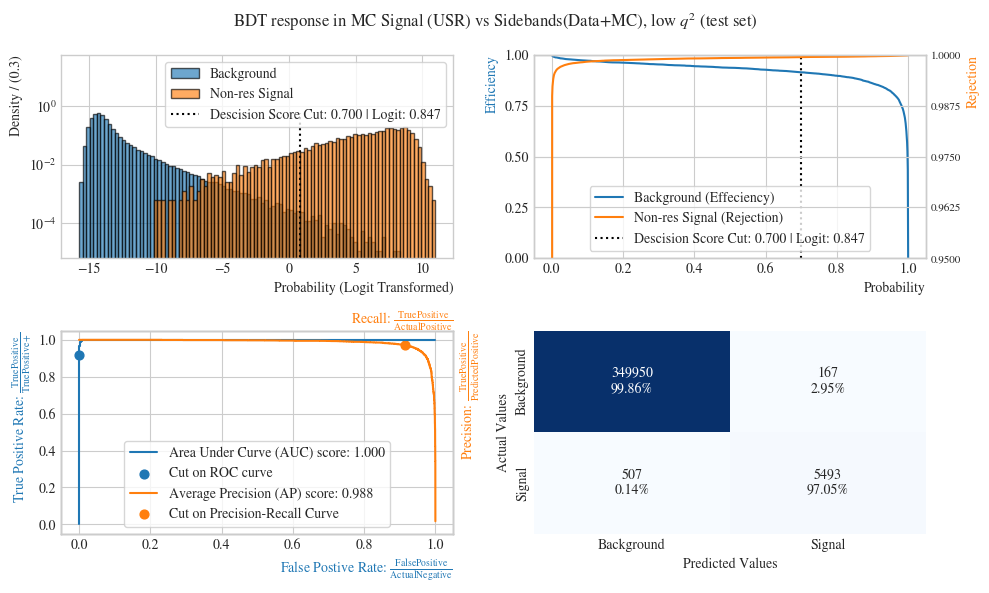

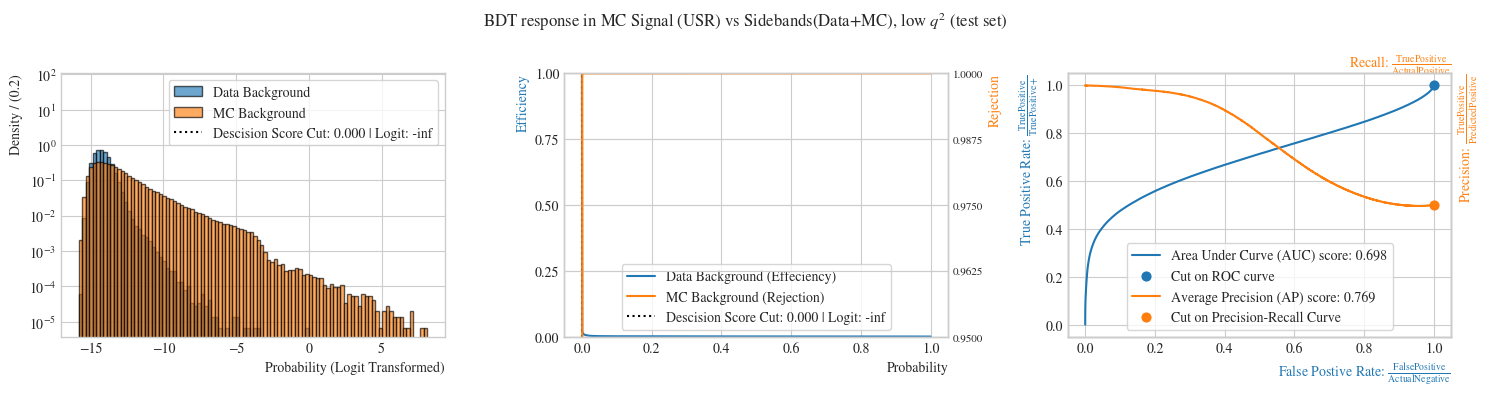

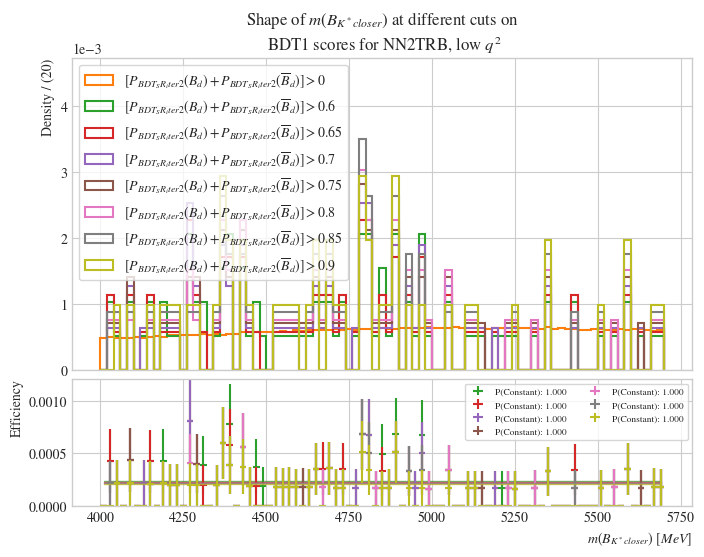

In [28]:
def Verstack_Optimization_plots(root_tag:str=None):
    P = plotting.Verstack_train_plots()
    fig = plt.figure(figsize=(12,3))
    P.plot_optimization_history(Storage.read_pd(key=f"{root_tag}/tuner"),fig=fig,placement=131)
    P.plot_param_imp(Storage.read_pd(key=f"{root_tag}/tuner_param_imp"),fig=fig,placement=132)
    P.plot_intermediate(Storage.read_pd(key=f"{root_tag}/tuner"),fig=fig,placement=133)
    plt.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+f"{root_tag}__optimization",bbox_inches = 'tight')
    plt.show()

Verstack_Optimization_plots(root_tag='BDT_SR_iter2')

BDT_SR_test=one_BDT_predicter(Storage,X_target = Sig_vs_BKG_SR_splits['X_test'],root_tag='BDT_SR_iter2')
Sig_vs_BKG_SR_MC_test=one_BDT_predicter(Storage,X_target = Sig_vs_BKG_SR_MC_test ,root_tag='BDT_SR_iter2')

def MC_Sig_Vs_Bkg_SR_response_curve(input_data, tag='BDT_SB'):
    #P = plotting.plot_response(input_data=X_test_BDT1,threshold=0.7,root_tag='BDT1',test_data = True)
    P = plot_response(input_data=input_data,threshold=0.7,root_tag=tag,test_data = True)
    fig = plt.figure(figsize=(10,6))
    title=''
    P.plot_descision_scores(fig=fig,placemenent=221,title=title,legend1='Background',legend2='Non-res Signal')
    title=''
    P.Plot_efficiency_rejection(fig=fig,placemenent=222,title=title,y_range=(0.95,1),legend2='Non-res Signal ',legend1='Background ')
    P.plot_roc_curve(fig=fig,placemenent=223)
    P.plot_confusionmatrix_3x3(fig=fig,placemenent=224,legend1='Signal',legend2='Background')
    main_title = "BDT response in MC Signal (USR) vs Sidebands(Data+MC), low $q^2$ (test set)"
    fig.suptitle(main_title)
    fig.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+f"{tag}_test",bbox_inches = 'tight')

    plt.show()
    
MC_Sig_Vs_Bkg_SR_response_curve(input_data=BDT_SR_test,tag='BDT_SR_iter2')

def MC_Sig_Vs_Bkg_SR_response_curve_TESTING_MC(input_data,tag='BDT_SB'):
    #P = plotting.plot_response(input_data=eval(f"Sig_vs_BKG_{tag.split('_')[-1]}_MC_test"),threshold=0,root_tag=tag,test_data = True,MC_TEST=True)
    P = plot_response(input_data=input_data,threshold=0,root_tag=tag,test_data = True)
    fig = plt.figure(figsize=(15,4))
    title=''
    P.plot_descision_scores(fig=fig,placemenent=131,title=title,legend2='MC Background',legend1='Data Background')
    title=''
    P.Plot_efficiency_rejection(fig=fig,placemenent=132,title=title,y_range=(0.95,1),legend2='MC Background ',legend1='Data Background ')
    P.plot_roc_curve(fig=fig,placemenent=133)
    #P.plot_confusionmatrix_3x3(fig=fig,placemenent=224,legend1='Signal',legend2='Background')
    main_title = "BDT response in MC Signal (USR) vs Sidebands(Data+MC), low $q^2$ (test set)"
    fig.suptitle(main_title)
    fig.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+f"{tag}_TESTING_MC",bbox_inches = 'tight')

    plt.show()
    
MC_Sig_Vs_Bkg_SR_response_curve_TESTING_MC(input_data = Sig_vs_BKG_SR_MC_test, tag='BDT_SR_iter2')

Test__SR = one_BDT_predicter(Storage,X_target = pd.concat([BKG_SR,BKG_MC.query(Utils.selection_cuts()['MC2'])]),root_tag='BDT_SR_iter2')

def plot_mass_shape_in_USR_wrapper():
    P = plot_mass_shape_in_USR(test_data=True)

    fig = plt.figure(figsize=(8,6))
    title='Shape of $m(B_{{K^* \t{{closer}}}})$ at different cuts on \n'+r" BDT1 scores for NN2TRB, low $q^2$"
    P.plot_mass(fig=fig,placemenent=111, input_data = Test__SR, target = 'B_mass_Kstar_mass_closer', title=title, root_tag='BDT_SR_iter2')
 
    #title='Shape of $m(B_{{K^* \t{{closer}}}})$ at different cuts on \n'+r" BDT2 scores for NN2TRB, low $q^2$"
    #P.plot_mass(fig=fig,placemenent=122, input_data = Test__SR, target = 'B_mass_Kstar_mass_closer', title=title, root_tag='BDT_SR')
    plt.savefig(config['PATHS']['figure_save']+"_BDT_SR_iter2_"+f"_TESTING_leak_SR",bbox_inches = 'tight')


    plt.show() 

plot_mass_shape_in_USR_wrapper()

Init Native LGBM importances (test)...
Done with Native LGBM importances
Init SHAP importances (train)...
Done with SHAP importances
Init SHAP importances (test)...
Done with SHAP importances


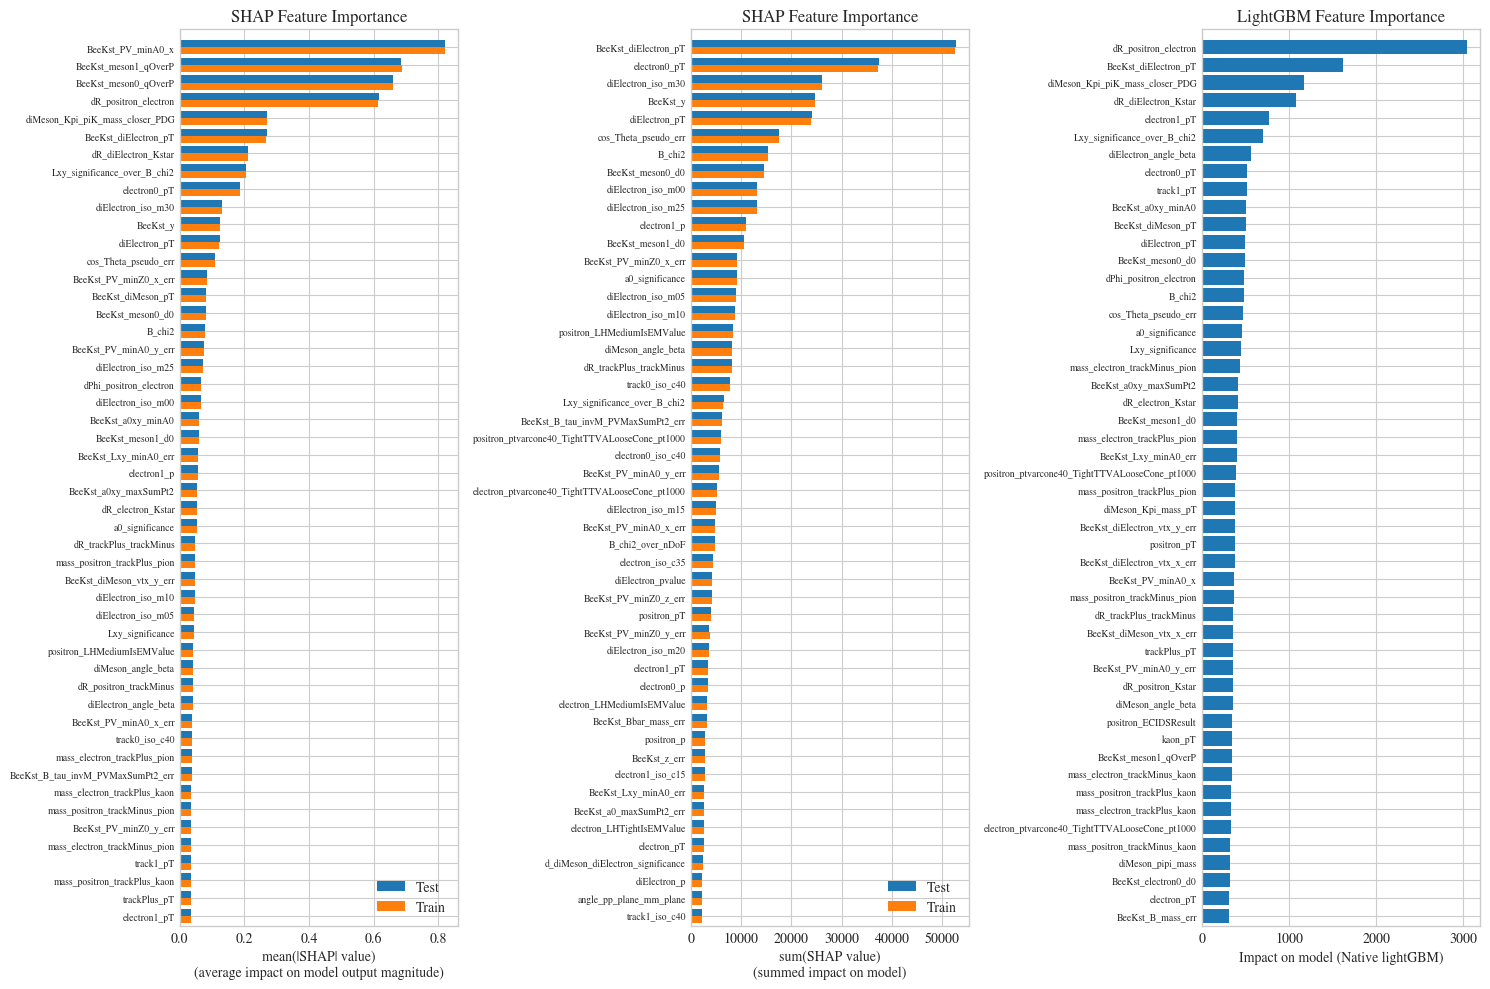

In [29]:
def AUC_score(y_truth, y_pred):
    fpr, tpr, _ = metrics.roc_curve(list(y_truth), list(y_pred))                 # False/True Positive Rate for our model
    auc_score = metrics.auc(fpr,tpr) 
    return auc_score

if __name__ == "__main__":

    get_importance = feature_importance(data=BDT_SR_test,root_tag='BDT_SR_iter2')
    get_importance.Native_lgbm(label='test')
    get_importance.SHAP(X_data=Sig_vs_BKG_SR_splits['X_train_scaled'].sample(200000),label='train')
    get_importance.SHAP(X_data=Sig_vs_BKG_SR_splits['X_test_scaled'].sample(200000),label='test')
    #get_importance.permutation_importance(Sig_vs_BKG_SB_splits['X_test_scaled'],Sig_vs_BKG_SB_splits['y_test'],scorer=AUC_score,label='test',sample=200000)
    #get_importance.permutation_importance(Sig_vs_BKG_SB_splits['X_train_scaled'],Sig_vs_BKG_SB_splits['y_train'],scorer=AUC_score,label='train',sample=200000)

    #get_importance.Permutation(X_data=Sig_vs_BKG_SB_splits['X_train_scaled'][:100],y_data=Sig_vs_BKG_SB_splits['y_train'][:100],label='train',scorer=AUC_score,N_repeats=10)
    #get_importance.Permutation(X_data=Sig_vs_BKG_SB_splits['X_test_scaled'][:100],y_data=Sig_vs_BKG_SB_splits['y_test'][:100],label='test',scorer=AUC_score,N_repeats=10)

feature_imp_pd = get_importance.get_Frame()
Storage.write_pd(key='BDT_SR_iter2_Feature_importance', df=feature_imp_pd, overwrite=True)

def feature_importance_plots():

    P=Feature_Importance_plots(N=50)

    fig = plt.figure(figsize=(15,10))
    P.plot_shap_mean(fig=fig,placemenent=131,importance_data1= feature_imp_pd.SHAP_mean_test.sort_values(), importance_data2 = feature_imp_pd.SHAP_mean_train.sort_values(), label1 = 'Test', label2 = 'Train')
    P.plot_shap_sum(fig=fig,placemenent=132,importance_data1= feature_imp_pd.SHAP_sum_test.sort_values(), importance_data2 = feature_imp_pd.SHAP_sum_train.sort_values(), label1 = 'Test', label2 = 'Train')

    #P.plot_permute(fig=fig,placemenent=132,importance_data1= (-1*feature_imp_pd.perm_test).sort_values(), label1 = 'Test', label2 = 'Train')
    P.plot_native(fig=fig,placemenent=133,importance_data = feature_imp_pd.Native_test.sort_values())
    #P.plot_neg_permute(fig=fig,placemenent=133)
    plt.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+"_BDT_SR_iter2_Feature_importances.pdf")
    plt.show()

feature_importance_plots()

In [31]:
def Data_loader():
    N_times_signal = 4
    print('Loading MC signal..')
    SIG_MC=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['USR'], columns=None, use_threads=True, storage_options=None)
    SIG_MC = SIG_MC.query(Utils.selection_cuts()['usr_lowq2'])
    SIG_MC.drop(SIG_MC[~((SIG_MC.BeeKst_isTrueNonresBd==1) | (SIG_MC.BeeKst_isTrueNonresBdbar==1))].index,inplace=True)
    SIG_MC.drop(SIG_MC[(SIG_MC.BeeKst_isTrueNonresBd==1)].index[N_times_signal*config['ML_config']['N_Signal']['Bd']:],inplace=True)
    SIG_MC.drop(SIG_MC[(SIG_MC.BeeKst_isTrueNonresBdbar==1)].index[N_times_signal*config['ML_config']['N_Signal']['BdBar']:],inplace=True)

    label = (SIG_MC.info_sample == 0)*0
    for i in config['labels B_VS_BBar']:
        label += (SIG_MC.info_sample == str(i))*config['labels B_VS_BBar'][str(i)]
    SIG_MC['label'] = label

    return SIG_MC

B_vs_Bbar = Data_loader()

B_vs_Bbar = pd.concat([B_vs_Bbar])
B_vs_Bbar_splits = train_test_split_stratified(B_vs_Bbar)

Utils.fit_scaler_to_train(Storage,B_vs_Bbar_splits['X_train'][features],root_tag='BDT_BBbar_iter2')
B_vs_Bbar_splits['X_train_scaled'] = Utils.pd_scale(Storage,B_vs_Bbar_splits['X_train'][features], root_tag= 'BDT_BBbar_iter2', target_tag = 'X_train')
B_vs_Bbar_splits['X_test_scaled'] = Utils.pd_scale(Storage,B_vs_Bbar_splits['X_test'][features], root_tag= 'BDT_BBbar_iter2', target_tag = 'X_test')

Loading MC signal..


In [32]:
%%capture --no-stdout

def Run_tuner(X_,y_,Storage=Storage,root_tag='BDT_MC'):

    assert str(type(Storage).__module__) == "Storage.Global", "Input Storage is not a correct global storage initialized from the HDF5_IO-function"

    np.random.seed(42)
    #print(f"Training LGBM with {Storage.read_pd(key=f"{root_tag}/X_train").shape[1]} features")
    tuner = verstack.LGBMTuner(metric = 'log_loss',trials=100, visualization = False, seed = 42,verbosity=1)
    
    tuner.fit(X=X_,y=y_.astype(int).squeeze())

    Storage.write_pd(key=f"{root_tag}/tuner", df = tuner.study.trials_dataframe(attrs=('number', 'value', 'params', 'state','intermediate_values'),multi_index=True),overwrite=True)
    Storage.write_pd(key=f"{root_tag}/tuner_param_imp", df = pd.DataFrame([dict(optuna.importance.get_param_importances(tuner.study).items())]).T.rename(columns={0:'value'}),overwrite=True)
    Storage.save_lgbm(key=f"{root_tag}/model",tuner=tuner, feature_names = list(X_.columns), overwrite=True)

    print('Done with training model')
    return tuner

#tuner = Run_tuner(X_=B_vs_Bbar_splits['X_train_scaled'],y_=B_vs_Bbar_splits['y_train'],root_tag='BDT_BBbar_iter1')

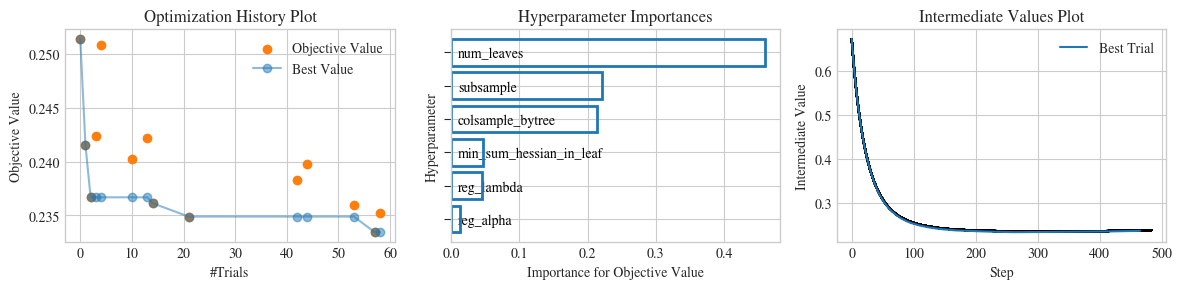

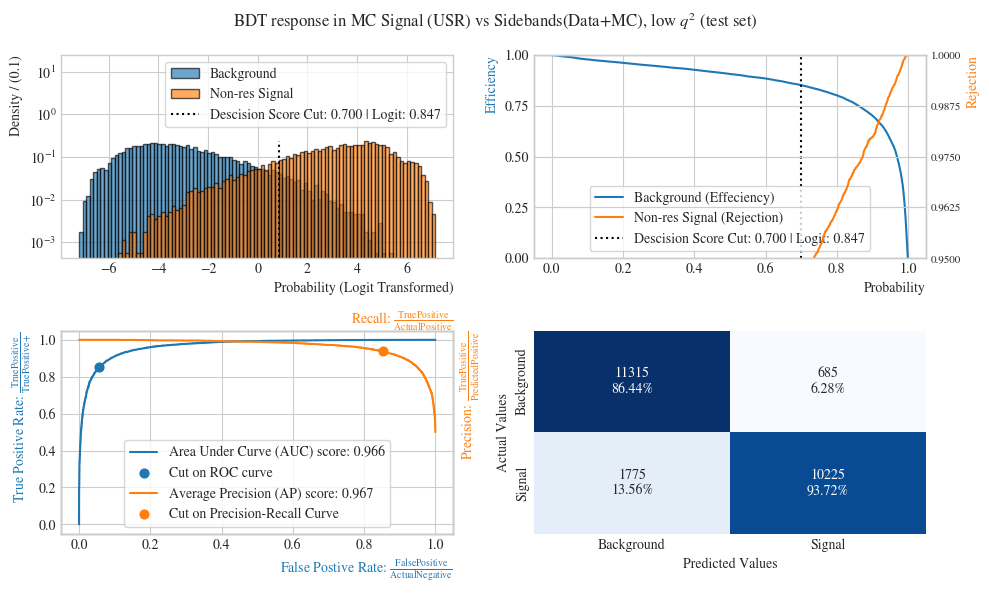

In [34]:
def Verstack_Optimization_plots(root_tag:str=None):
    P = plotting.Verstack_train_plots()
    fig = plt.figure(figsize=(12,3))
    P.plot_optimization_history(Storage.read_pd(key=f"{root_tag}/tuner"),fig=fig,placement=131)
    P.plot_param_imp(Storage.read_pd(key=f"{root_tag}/tuner_param_imp"),fig=fig,placement=132)
    P.plot_intermediate(Storage.read_pd(key=f"{root_tag}/tuner"),fig=fig,placement=133)
    plt.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+f"{root_tag}__optimization",bbox_inches = 'tight')
    plt.show()

Verstack_Optimization_plots(root_tag='BDT_BBbar_iter2')

BDT_BBbar_test=one_BDT_predicter(Storage,X_target = B_vs_Bbar_splits['X_test'],root_tag='BDT_BBbar_iter2')

def MC_Sig_Vs_Bkg_SR_response_curve(input_data, tag='BDT_SB'):
    #P = plotting.plot_response(input_data=X_test_BDT1,threshold=0.7,root_tag='BDT1',test_data = True)
    P = plot_response(input_data=input_data,threshold=0.7,root_tag=tag,test_data = True)
    fig = plt.figure(figsize=(10,6))
    title=''
    P.plot_descision_scores(fig=fig,placemenent=221,title=title,legend1='Background',legend2='Non-res Signal')
    title=''
    P.Plot_efficiency_rejection(fig=fig,placemenent=222,title=title,y_range=(0.95,1),legend2='Non-res Signal ',legend1='Background ')
    P.plot_roc_curve(fig=fig,placemenent=223)
    P.plot_confusionmatrix_3x3(fig=fig,placemenent=224,legend1='Signal',legend2='Background')
    main_title = "BDT response in MC Signal (USR) vs Sidebands(Data+MC), low $q^2$ (test set)"
    fig.suptitle(main_title)
    fig.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+f"{tag}_test",bbox_inches = 'tight')

    plt.show()
    
MC_Sig_Vs_Bkg_SR_response_curve(input_data=BDT_BBbar_test,tag='BDT_BBbar_iter2')


Init Native LGBM importances (test)...
Done with Native LGBM importances
Init SHAP importances (train)...
Done with SHAP importances
Init SHAP importances (test)...
Done with SHAP importances


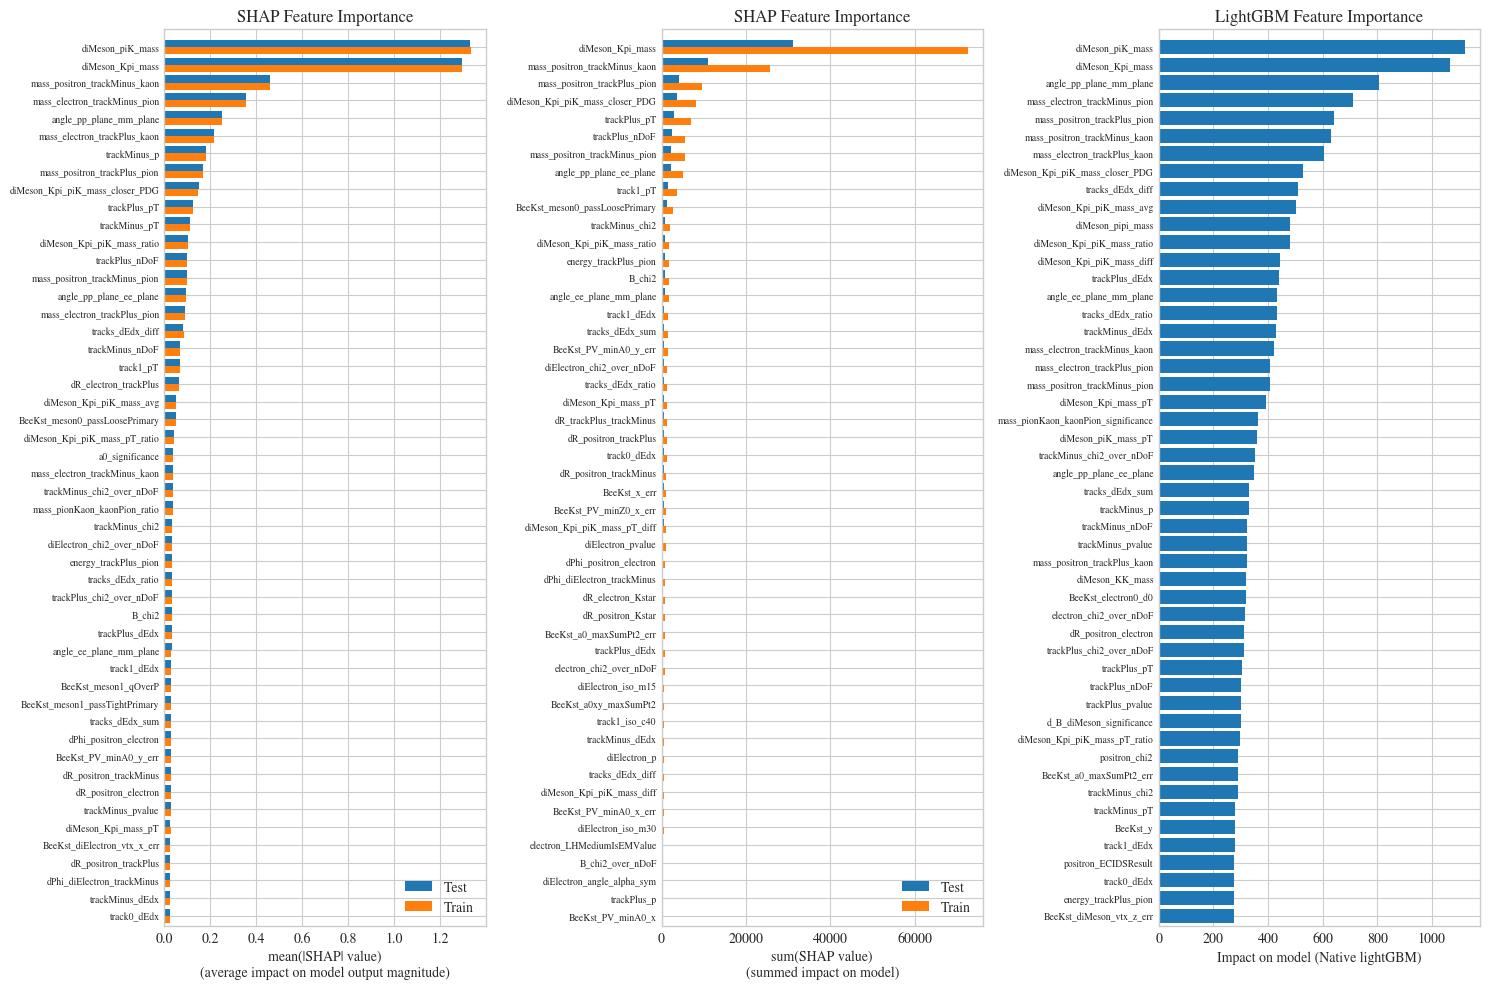

In [35]:
def AUC_score(y_truth, y_pred):
    fpr, tpr, _ = metrics.roc_curve(list(y_truth), list(y_pred))                 # False/True Positive Rate for our model
    auc_score = metrics.auc(fpr,tpr) 
    return auc_score

if __name__ == "__main__":

    get_importance = feature_importance(data=BDT_BBbar_test,root_tag='BDT_BBbar_iter2')
    get_importance.Native_lgbm(label='test')
    get_importance.SHAP(X_data=B_vs_Bbar_splits['X_train_scaled'],label='train')
    get_importance.SHAP(X_data=B_vs_Bbar_splits['X_test_scaled'],label='test')
    #get_importance.permutation_importance(Sig_vs_BKG_SB_splits['X_test_scaled'],Sig_vs_BKG_SB_splits['y_test'],scorer=AUC_score,label='test',sample=200000)
    #get_importance.permutation_importance(Sig_vs_BKG_SB_splits['X_train_scaled'],Sig_vs_BKG_SB_splits['y_train'],scorer=AUC_score,label='train',sample=200000)

    #get_importance.Permutation(X_data=Sig_vs_BKG_SB_splits['X_train_scaled'][:100],y_data=Sig_vs_BKG_SB_splits['y_train'][:100],label='train',scorer=AUC_score,N_repeats=10)
    #get_importance.Permutation(X_data=Sig_vs_BKG_SB_splits['X_test_scaled'][:100],y_data=Sig_vs_BKG_SB_splits['y_test'][:100],label='test',scorer=AUC_score,N_repeats=10)

feature_imp_pd = get_importance.get_Frame()
Storage.write_pd(key='BDT_BBbar_iter2_Feature_importance', df=feature_imp_pd, overwrite=True)

def feature_importance_plots():

    P=Feature_Importance_plots(N=50)

    fig = plt.figure(figsize=(15,10))
    P.plot_shap_mean(fig=fig,placemenent=131,importance_data1= feature_imp_pd.SHAP_mean_test.sort_values(), importance_data2 = feature_imp_pd.SHAP_mean_train.sort_values(), label1 = 'Test', label2 = 'Train')
    P.plot_shap_sum(fig=fig,placemenent=132,importance_data1= feature_imp_pd.SHAP_sum_test.sort_values(), importance_data2 = feature_imp_pd.SHAP_sum_train.sort_values(), label1 = 'Test', label2 = 'Train')

    #P.plot_permute(fig=fig,placemenent=132,importance_data1= (-1*feature_imp_pd.perm_test).sort_values(), label1 = 'Test', label2 = 'Train')
    P.plot_native(fig=fig,placemenent=133,importance_data = feature_imp_pd.Native_test.sort_values())
    #P.plot_neg_permute(fig=fig,placemenent=133)
    plt.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+"_BDT_BBbar_iter2_Feature_importances.pdf")
    plt.show()

feature_importance_plots()

# Moving to Iteration2:
Get the best 50 for each

In [55]:
Imp_BBbar = Storage.read_pd(key='BDT_BBbar_iter1_Feature_importance')
Imp_SR = Storage.read_pd(key='BDT_SR_iter1_Feature_importance')
Imp_SB = Storage.read_pd(key='BDT_SB_iter1_Feature_importance')

In [78]:

A1 = set(list(Imp_BBbar.Native_test.sort_values(ascending=False).index)[:50])
A2 = set(list(Imp_BBbar.SHAP_sum_test.sort_values(ascending=False).index)[:50])
A3 = set(list(Imp_BBbar.SHAP_sum_train.sort_values(ascending=False).index)[:50])
A4 = set(list(Imp_BBbar.SHAP_mean_test.sort_values(ascending=False).index)[:50])
A5 = set(list(Imp_BBbar.SHAP_mean_train.sort_values(ascending=False).index)[:50])

A = A1.union(A2).union(A3).union(A4).union(A5)
print(len(A))


B1 = set(list(Imp_SR.Native_test.sort_values(ascending=False).index)[:50])
B2 = set(list(Imp_SR.SHAP_sum_test.sort_values(ascending=False).index)[:50])
B3 = set(list(Imp_SR.SHAP_sum_train.sort_values(ascending=False).index)[:50])
B4 = set(list(Imp_SR.SHAP_mean_test.sort_values(ascending=False).index)[:50])
B5 = set(list(Imp_SR.SHAP_mean_train.sort_values(ascending=False).index)[:50])

B = B1.union(B2).union(B3).union(B4).union(B5)
print(len(B))


C1 = set(list(Imp_SB.Native_test.sort_values(ascending=False).index)[:50])
C2 = set(list(Imp_SB.SHAP_sum_test.sort_values(ascending=False).index)[:50])
C3 = set(list(Imp_SB.SHAP_sum_train.sort_values(ascending=False).index)[:50])
C4 = set(list(Imp_SB.SHAP_mean_test.sort_values(ascending=False).index)[:50])
C5 = set(list(Imp_SB.SHAP_mean_train.sort_values(ascending=False).index)[:50])

C = C1.union(C2).union(C3).union(C4).union(C5)
print(len(C))

ABC = A.union(B).union(C)
print(len(ABC))

92
86
91
158


In [79]:
print(list(ABC))

['trackMinus_pT', 'BeeKst_Bbar_tau_invM_PVMinA0', 'electron_LHTightIsEMValue', 'dR_electron_trackPlus', 'track1_p', 'Lxy_significance_over_B_chi2', 'trackPlus_chi2_over_nDoF', 'trackMinus_p', 'diMeson_Kpi_piK_mass_ratio', 'mass_electron_trackMinus_kaon', 'track1_iso_c40', 'mass_electron_trackPlus_kaon', 'BeeKst_PV_minZ0_z_err', 'diMeson_Kpi_piK_mass_pT_ratio', 'B_chi2', 'dPhi_diElectron_trackMinus', 'mass_electron_trackPlus_pion', 'diMeson_piK_mass_pT', 'dR_trackPlus_trackMinus', 'electron1_pT', 'BeeKst_diElectron_pT', 'diElectron_pvalue', 'energy_trackPlus_pion', 'diMeson_angle_beta', 'B_chi2_over_nDoF', 'BeeKst_meson0_qOverP', 'dR_diElectron_trackPlus', 'BeeKst_z0_maxSumPt2', 'B_pvalue', 'positron_pT', 'diMeson_Kpi_piK_mass_diff', 'diElectron_iso_m25', 'diMeson_KK_mass', 'positron_ECIDSResult', 'diElectron_chi2_over_nDoF', 'BeeKst_diElectron_vtx_y_err', 'tracks_dEdx_diff', 'dPhi_positron_electron', 'BeeKst_meson1_d0', 'BeeKst_a0xy_maxSumPt2', 'BeeKst_diMeson_vtx_y_err', 'positron_p',

In [7]:
def apply_local_candidate(data:pd.core.frame.DataFrame, apply_on_column:str = 'P_BDT_min', is_test:bool = True) -> pd.core.frame.DataFrame:
    """ Applies local candidate selection based on the "apply_on_column". Default is P_BDT_min since we want to find the largest of the minimum.

    Args:
        data (pd.core.frame.DataFrame): Data on which we want to apply local candidate selection
        apply_on_column (str, optional): Column we sort on. Defaults to 'P_BDT_min'.
        is_test (bool, optional): If this is a test, we do not sort. Defaults to True.

    Returns:
        pd.core.frame.DataFrame: Dublicates are removed.
    """
    if is_test == False:
        assert 'info_event_number' in list(data.columns), 'info_event_number is not in "data"..'
        return data.sort_values('P_BDT_min').groupby(['info_event_number']).tail(1).sort_index()
    else:
        return data

def add_BDT_score(data:pd.core.frame.DataFrame,root_tag: str = 'BDT_BBbar') -> pd.core.frame.DataFrame:
    """ Applis BDT scores to the data using the BDT model from model_root.
    A new columnt of BDT scores are applied.

    Args:
        data (pd.core.frame.DataFrame): Input data
        model_root (str, optional): BDT model string tag from HDF5-storage. Defaults to 'BDT_BBbar'.

    Returns:
        pd.core.frame.DataFrame: out put data with added columns: BDT scores
    """
    model = Storage.load_lgbm(key=f"{root_tag}/model")
    feat_idx = model.feature_name()
    data_reduced=data[feat_idx]

    data_scaled = Utils.pd_scale(Storage,data_reduced, root_tag= root_tag)
    BDT_scores = model.predict(data_scaled.reindex(columns=feat_idx))

    data[f"P_{root_tag}"] = BDT_scores
    return data
    

def bkg_mass_shape_metric(input_data: pd.core.frame.DataFrame = None, target:str = 'B_mass_Kstar_mass_closer',root_tag:str=None,xrange_bins:tuple=(4000,5700,85)) -> float:
    Data = input_data.copy()

    ## FIT LINEAR:
    def linear_fit(x,a, b):
        return a*x + b  

    Data = apply_local_candidate(Data, apply_on_column='P_BDT_min', is_test=True)
    Data = add_BDT_score(Data, root_tag = 'BDT_BBbar')
    Data['mass_hypotesis'] = ['BDbar' if x >= 0.5 else 'Bd' for x in Data[f"P_{'BDT_BBbar'}"]]

    Data=Data[(Data['mass_hypotesis']=='Bd')]


    xrange=xrange_bins[:2]
    bins= xrange_bins[2]
    bindwidth = (xrange[1]-xrange[0])/bins

    bench, edges = np.histogram(Data.eval(f"{target}"),bins=bins,range=xrange,density=False)

    centers  = 0.5*(edges[1:] + edges[:-1])
    heights = []

    cut_range = [0,0.6,0.65,0.7,0.75,0.8,0.85,0.9]

    for i in range(len(cut_range)):
        cut = cut_range[i]
        bin_hights ,_ = np.histogram(Data.eval(f"{target}")[(Data.eval(f"P_{root_tag}") > cut)],bins=bins,range=xrange,density=False)

        heights.append(bin_hights)

    res_lin = []

    for i in range(1,len(heights)):
        bench = heights[0]
        Eff=np.divide(heights[i],bench)
        Eff_yerr=np.sqrt(np.divide(np.multiply(Eff, np.subtract(np.ones(Eff.size), Eff)), bench)) #Binomial error

        Eff_yerr, centers_Eff, Eff=Eff_yerr[~np.isnan(Eff)], centers[~np.isnan(Eff)], Eff[~np.isnan(Eff)]
        
        mask_mean = (Eff_yerr)!=0
        mean = np.mean(Eff)

        Init_fit = {'a': [0,None,None,True],'b': [mean,0,1,False],} # Initial Guess, #limit1, limit2 and fix=False
        minuit_chi2_object = Utils.Chi2Regression(linear_fit, centers_Eff[mask_mean], Eff[mask_mean],Eff_yerr[mask_mean],bound=xrange) 
        iminut_initializer = Utils.iminut_value_initializer(Init_fit,linear_fit)
        minuit_chi2 = Minuit(minuit_chi2_object, *iminut_initializer.init_values(), name = iminut_initializer.names())
        minuit_chi2.errordef = Minuit.LEAST_SQUARES     # Value for likelihood fits
        iminut_initializer.limits_and_fixed(minuit_chi2)
        minuit_chi2.migrad()
        minuit_chi2.hesse()
        if (not minuit_chi2.fmin.is_valid) :
            print("  WARNING: fit DID NOT converge!!! ") 
        N_NotEmptyBin = np.sum(Eff > 0)
        Ndof_value = N_NotEmptyBin - minuit_chi2.nfit
        res_lin.append(scipy.stats.chi2.sf(minuit_chi2.fval, Ndof_value)) # The chi2 probability given N_DOF degrees of freedom  

    return np.mean(np.array(res_lin))

def mass_sculping_feature_importance(X_data = None, root_tag:str = 'BDT_SB', iterations:int =1):
    Data = X_data.copy()
    model = Storage.load_lgbm(key=f"{root_tag}/model")
    feat_idx = model.feature_name()

    Data = add_BDT_score(Data, root_tag = root_tag)
    # base score, the lower the better:
    base_score = bkg_mass_shape_metric(input_data = Data, target = 'B_mass_Kstar_mass_closer', root_tag=root_tag)
    # Create an empty list to store the feature importances
    importances = []

    # For each feature
    for feature in list(feat_idx):
        mean = []
        for i in range(iterations):
            # Create a copy of the test set with the current feature shuffled
            X_test_shuffled = Data.copy()
            X_test_shuffled[feature] = np.random.permutation(X_test_shuffled[feature]) 

            X_test_shuffled = add_BDT_score(X_test_shuffled, root_tag = root_tag)        
            # Calculate the accuracy of the shuffled test set
            mean.append(bkg_mass_shape_metric(input_data = X_test_shuffled, target = 'B_mass_Kstar_mass_closer', root_tag=root_tag))
        new_score = np.mean(np.array(mean))  

        importances.append({'index': feature,
                    'Mass_Sculping': new_score - base_score })
    
    perm_df = pd.DataFrame(importances).set_index('index')
    
    return perm_df

In [8]:
X_target = pd.concat([BKG_SB,BKG_MC.query(Utils.selection_cuts()['MC2'])])
BKG_SB_mass_sculping = mass_sculping_feature_importance(X_data = X_target, root_tag= 'BDT_SB_iter2')

Storage.write_pd(key='BDT_SB_iter2_Feature_importance_MASS', df=BKG_SB_mass_sculping, overwrite=True)
#feature_imp_pd.merge(Test1, how='left',left_index=True,right_index=True)

In [9]:
X_target = pd.concat([BKG_SR,BKG_MC.query(Utils.selection_cuts()['MC2'])])
BKG_SR_mass_sculping = mass_sculping_feature_importance(X_data = X_target, root_tag= 'BDT_SR_iter2')

Storage.write_pd(key='BDT_SR_iter2_Feature_importance_MASS', df=BKG_SR_mass_sculping, overwrite=True)

In [8]:
BKG_SB_mass_sculping = Storage.read_pd(key='BDT_SB_iter2_Feature_importance_MASS')
BKG_SR_mass_sculping = Storage.read_pd(key='BDT_SR_iter2_Feature_importance_MASS')

In [11]:
BKG_SB_mass_sculping.Mass_Sculping.sort_values()

index
dR_positron_electron          -9.999990e-01
dR_diElectron_Kstar           -4.548978e-01
BeeKst_meson0_qOverP          -6.345641e-04
BeeKst_diElectron_pT          -2.652372e-04
BeeKst_meson1_qOverP          -2.494970e-04
                                   ...     
tracks_dEdx_sum                8.728569e-07
pion_pT                        8.967384e-07
BeeKst_diMeson_pT              9.472286e-07
BeeKst_diElectron_vtx_x_err    9.509824e-07
electron1_pT                   9.886813e-07
Name: Mass_Sculping, Length: 158, dtype: float64

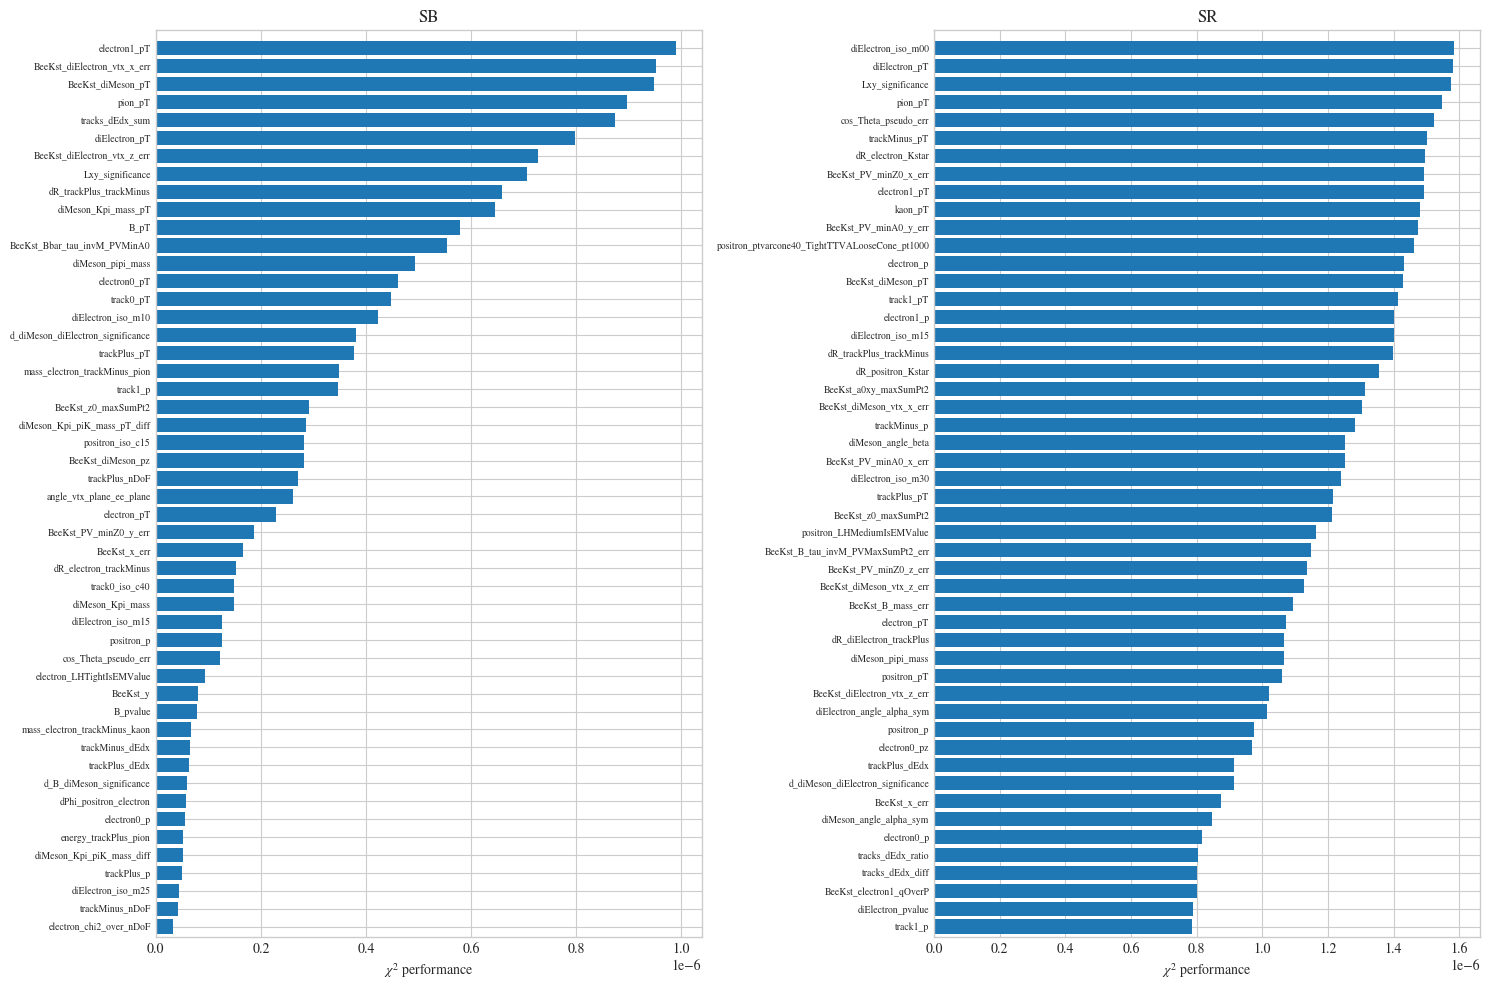

In [16]:

def feature_importance_plots():

    P=Feature_Importance_plots(N=50)

    fig = plt.figure(figsize=(15,10))
    #P.plot_permute(fig=fig,placemenent=132,importance_data1= (-1*feature_imp_pd.perm_test).sort_values(), label1 = 'Test', label2 = 'Train')
    P.plot_mass_sculp(fig=fig,placemenent=121,importance_data = BKG_SB_mass_sculping.Mass_Sculping.sort_values(), title = 'SB')
    P.plot_mass_sculp(fig=fig,placemenent=122,importance_data = BKG_SR_mass_sculping.Mass_Sculping.sort_values(), title = 'SR')
    #P.plot_neg_permute(fig=fig,placemenent=133)
    plt.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+"iter2_mass_sculping.pdf")
    plt.show()

feature_importance_plots()

In [17]:
Imp_BBbar = Storage.read_pd(key='BDT_BBbar_iter2_Feature_importance')
Imp_SR = Storage.read_pd(key='BDT_SR_iter2_Feature_importance')
Imp_SB = Storage.read_pd(key='BDT_SB_iter2_Feature_importance')

In [24]:

A1 = set(list(Imp_BBbar.Native_test.sort_values(ascending=False).index)[:20])
A2 = set(list(Imp_BBbar.SHAP_sum_test.sort_values(ascending=False).index)[:20])
A3 = set(list(Imp_BBbar.SHAP_sum_train.sort_values(ascending=False).index)[:20])
A4 = set(list(Imp_BBbar.SHAP_mean_test.sort_values(ascending=False).index)[:20])
A5 = set(list(Imp_BBbar.SHAP_mean_train.sort_values(ascending=False).index)[:20])

A = A1.union(A2).union(A3).union(A4).union(A5)
print(len(A))


B1 = set(list(Imp_SR.Native_test.sort_values(ascending=False).index)[:20])
B2 = set(list(Imp_SR.SHAP_sum_test.sort_values(ascending=False).index)[:20])
B3 = set(list(Imp_SR.SHAP_sum_train.sort_values(ascending=False).index)[:20])
B4 = set(list(Imp_SR.SHAP_mean_test.sort_values(ascending=False).index)[:20])
B5 = set(list(Imp_SR.SHAP_mean_train.sort_values(ascending=False).index)[:20])

B = B1.union(B2).union(B3).union(B4).union(B5)
print(len(B))


C1 = set(list(Imp_SB.Native_test.sort_values(ascending=False).index)[:20])
C2 = set(list(Imp_SB.SHAP_sum_test.sort_values(ascending=False).index)[:20])
C3 = set(list(Imp_SB.SHAP_sum_train.sort_values(ascending=False).index)[:20])
C4 = set(list(Imp_SB.SHAP_mean_test.sort_values(ascending=False).index)[:20])
C5 = set(list(Imp_SB.SHAP_mean_train.sort_values(ascending=False).index)[:20])

C = C1.union(C2).union(C3).union(C4).union(C5)
print(len(C))

D1 = set(list(BKG_SB_mass_sculping.Mass_Sculping.sort_values(ascending=False).index)[:20])
D2 = set(list(BKG_SR_mass_sculping.Mass_Sculping.sort_values(ascending=False).index)[:20])

D = D1.union(D2)
print(len(D))

ABCD = A.union(B).union(C).union(D)
print(len(ABCD))

36
37
34
34
86


In [26]:
print(list(ABCD))

['mass_positron_trackPlus_pion', 'BeeKst_Bbar_tau_invM_PVMinA0', 'diElectron_angle_beta', 'diMeson_piK_mass', 'energy_trackPlus_pion', 'trackMinus_pT', 'BeeKst_diMeson_pT', 'BeeKst_meson1_d0', 'angle_pp_plane_ee_plane', 'BeeKst_a0xy_minA0', 'BeeKst_PV_minZ0_y_err', 'tracks_dEdx_diff', 'BeeKst_meson0_d0', 'track1_p', 'dR_trackPlus_trackMinus', 'trackMinus_nDoF', 'positron_ptvarcone40_TightTTVALooseCone_pt1000', 'mass_positron_trackMinus_kaon', 'track0_iso_c40', 'electron1_pT', 'BeeKst_PV_minA0_x', 'tracks_dEdx_ratio', 'BeeKst_diElectron_pT', 'diMeson_pipi_mass', 'diMeson_Kpi_mass_pT', 'diMeson_Kpi_mass', 'Lxy_significance_over_B_chi2', 'diMeson_Kpi_piK_mass_ratio', 'trackPlus_dEdx', 'BeeKst_B_tau_invM_PVMaxSumPt2_err', 'trackPlus_pT', 'Lxy_significance', 'diElectron_iso_m25', 'diMeson_Kpi_piK_mass_diff', 'BeeKst_meson1_qOverP', 'd_diMeson_diElectron_significance', 'trackMinus_chi2', 'mass_electron_trackMinus_kaon', 'angle_pp_plane_mm_plane', 'a0_significance', 'diElectron_chi2_over_nDoF